# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.metrics import mean_absolute_error
import warnings

# Set settings

In [2]:
pd.set_option('display.max_columns', None)
%matplotlib inline

# Read in data

In [3]:
data = pd.read_csv('smmh.csv')

# Feature engineering

Create feature for each type of social media (1 = uses platform, 0 = does not use platform) and number of social media platforms used

In [4]:
unique_social_medias = set()
data['7. What social media platforms do you commonly use?'] = data['7. What social media platforms do you commonly use?'].str.strip()
for item in data['7. What social media platforms do you commonly use?']:
    words = item.split(',')
    unique_social_medias.update(words)
unique_social_medias = list(unique_social_medias)
unique_social_medias = [word.strip() for word in unique_social_medias]
unique_social_medias = list(set(unique_social_medias))
data['Number of Social Media Platforms'] = 0
for social_media in unique_social_medias:
    data[social_media] = data['7. What social media platforms do you commonly use?'].apply(lambda x: 1 
                                                                                           if social_media in x 
                                                                                           else 0)
    data['Number of Social Media Platforms'] += data[social_media]

Create binary features based on Gender, Relationship Status, Occupation Status, and Use of Social Media

In [5]:
data['Male'] = data['2. Gender'].apply(lambda x: 1 if x=='Male' else 0)
data['Female'] = data['2. Gender'].apply(lambda x: 1 if x=='Female' else 0)
data['Married'] = data['3. Relationship Status'].apply(lambda x: 1 if x=='Married' else 0)
data['In a relationship'] = data['3. Relationship Status'].apply(lambda x: 1 if x=='In a relationship' else 0)
data['Single'] = data['3. Relationship Status'].apply(lambda x: 1 if x=='Single' else 0)
data['Student'] = data['4. Occupation Status'].apply(lambda x: 1 if x=='University Student' or x=='School Student' else 0)
data['Social Media'] = data['6. Do you use social media?'].apply(lambda x: 1 if x=='Yes' else 0)

Create three variables of interest relating to mental health: Mean Attention, Mean Mood, and Mean Anxiety. Each is based off of the responses to three other questions related to that category from the original questionnaire.

In [6]:
data['Mean Attention'] = (data['10. How often do you get distracted by Social media when you are busy doing something?'] + \
                          data['12. On a scale of 1 to 5, how easily distracted are you?'] + \
                          data['14. Do you find it difficult to concentrate on things?']) / 3.0

value_mapping = {
    5: 1,
    4: 2,
    3: 3,
    2: 4,
    1: 5
}

data['16. Following the previous question, how do you feel about these comparisons, generally speaking?'] = data['16. Following the previous question, how do you feel about these comparisons, generally speaking?'].replace(value_mapping)

data['Mean Mood'] = (data['16. Following the previous question, how do you feel about these comparisons, generally speaking?'] + \
                     data['18. How often do you feel depressed or down?'] + \
                     data['19. On a scale of 1 to 5, how frequently does your interest in daily activities fluctuate?'])/3.0

data['Mean Anxiety'] = (data["11. Do you feel restless if you haven't used Social media in a while?"] + \
                        data['13. On a scale of 1 to 5, how much are you bothered by worries?'] + \
                        data['20. On a scale of 1 to 5, how often do you face issues regarding sleep?']) / 3.0

data['Mean Mental Health'] = (data["Mean Attention"] + data['Mean Mood'] + data['Mean Anxiety']) / 3.0

# Select columns in dataframe to be used in subsequent analysis

In [7]:
data = pd.DataFrame(data[['1. What is your age?', 'Male', 'Female',
       'Married', 'In a relationship', 'Single', 'Student','Social Media',
       'YouTube', 'Facebook', 'TikTok', 'Reddit', 'Twitter', 'Pinterest',
       'Instagram', 'Snapchat', 'Discord', 'Number of Social Media Platforms',
       '8. What is the average time you spend on social media every day?',
       '9. How often do you find yourself using Social media without a specific purpose?',  
       '15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?',
       '17. How often do you look to seek validation from features of social media?',
       'Mean Attention', 'Mean Mood', 'Mean Anxiety', 'Mean Mental Health'
       ]])

# Bar charts for significant findings - mental health

In [8]:
def get_mean_by_group_t_test(df, groupby, agg_col):
    
    group1 = data.loc[data[groupby]==0, agg_col]
    group2 = data.loc[data[groupby]==1, agg_col]
    
    t_stat, p_value = stats.ttest_ind(group1, group2)
    
    if p_value < (.01 / 66):
        plt.figure(figsize=(4, 3))
        sns.barplot(x=groupby, y=agg_col, data=df)
        plt.xlabel(groupby)
        plt.ylabel('')
        plt.title(f'Mean of {agg_col} grouped by {groupby}')
        plt.show()
        
        print('')
        print(df.groupby(groupby).agg({agg_col: 'mean'}))
        print(f'p-value: {p_value:.4f}; t-statistic: {t_stat:.4f}')
        print('')

def get_mean_by_group(df, groupby, agg_col):
    if groupby == '8. What is the average time you spend on social media every day?':
        custom_order = ['Less than an Hour', 'Between 1 and 2 hours', 'Between 2 and 3 hours', 'Between 3 and 4 hours',
                       'Between 4 and 5 hours', 'More than 5 hours']

        df[groupby] = pd.Categorical(df[groupby], categories=custom_order, ordered=True)
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=groupby, y=agg_col, data=df)
    plt.xlabel('')
    plt.ylabel('')
    plt.title(f'Mean of {agg_col} grouped by {groupby}')
    plt.xticks(rotation=90)
    plt.show()
    
    print('')
    print(df.groupby(groupby).agg({agg_col: 'mean'}).sort_values(groupby))
    print('')

For binary columns, run independent samples t-test of two groups and show barcharts (and statistics) for the significant variables (Bonferroni corrected). For non-binary columns, show barcharts and means for all groups.

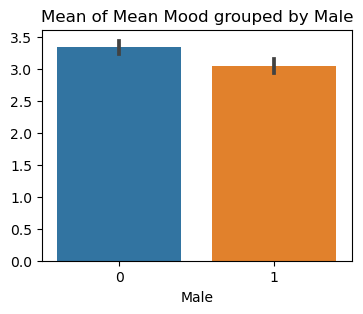


      Mean Mood
Male           
0      3.344444
1      3.053712
p-value: 0.0001; t-statistic: 3.9913



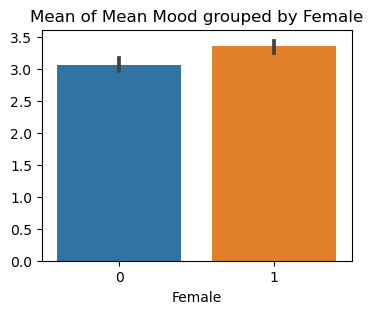


        Mean Mood
Female           
0        3.059633
1        3.347275
p-value: 0.0001; t-statistic: -3.9605



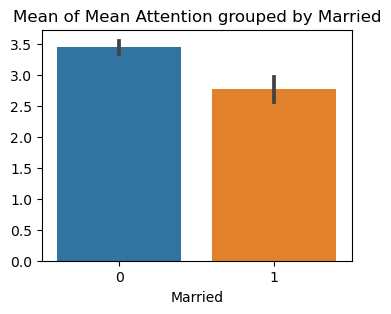


         Mean Attention
Married                
0              3.447368
1              2.768977
p-value: 0.0000; t-statistic: 5.6985



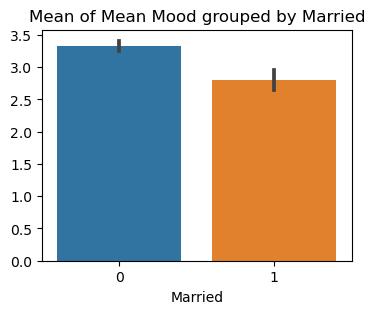


         Mean Mood
Married           
0         3.328947
1         2.795380
p-value: 0.0000; t-statistic: 6.1433



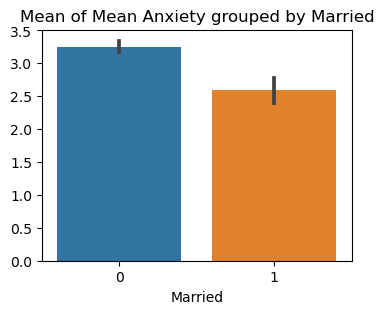


         Mean Anxiety
Married              
0            3.255263
1            2.594059
p-value: 0.0000; t-statistic: 6.3915



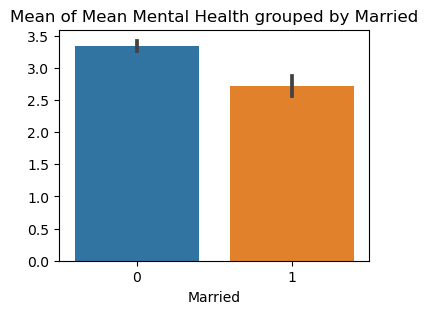


         Mean Mental Health
Married                    
0                  3.343860
1                  2.719472
p-value: 0.0000; t-statistic: 7.2035



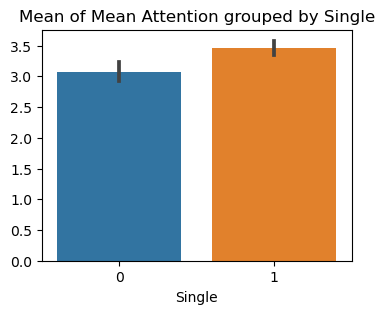


        Mean Attention
Single                
0             3.076531
1             3.461988
p-value: 0.0001; t-statistic: -3.8379



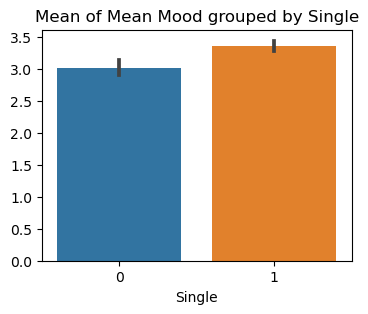


        Mean Mood
Single           
0        3.017007
1        3.354386
p-value: 0.0000; t-statistic: -4.6109



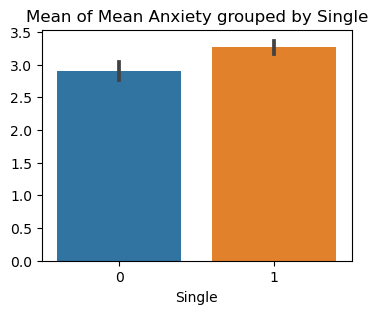


        Mean Anxiety
Single              
0           2.901361
1           3.264327
p-value: 0.0000; t-statistic: -4.1350



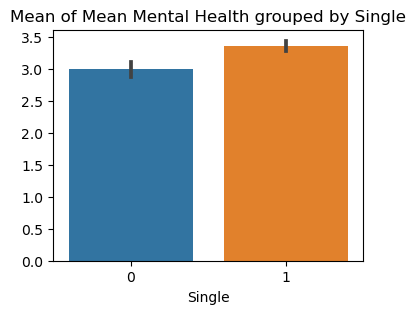


        Mean Mental Health
Single                    
0                 2.998299
1                 3.360234
p-value: 0.0000; t-statistic: -4.9036



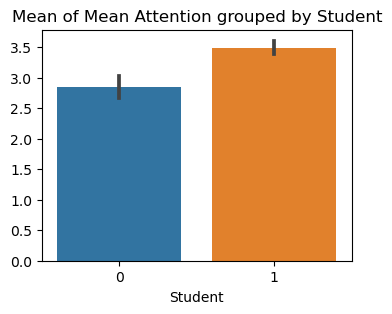


         Mean Attention
Student                
0              2.850000
1              3.491691
p-value: 0.0000; t-statistic: -6.0348



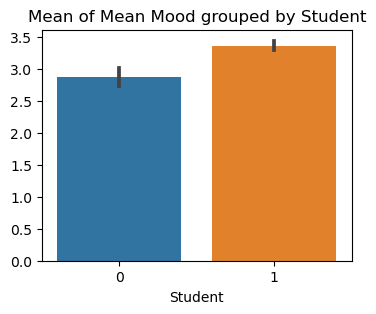


         Mean Mood
Student           
0         2.871429
1         3.358749
p-value: 0.0000; t-statistic: -6.2670



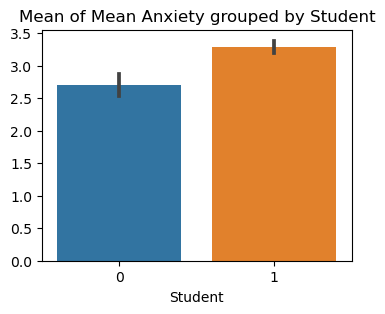


         Mean Anxiety
Student              
0            2.697619
1            3.288368
p-value: 0.0000; t-statistic: -6.3669



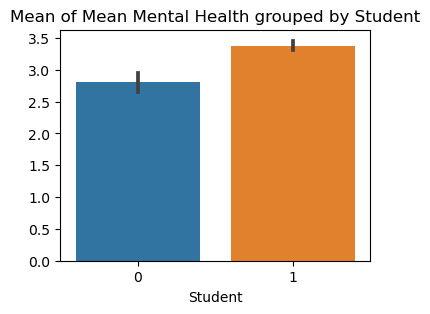


         Mean Mental Health
Student                    
0                  2.806349
1                  3.379602
p-value: 0.0000; t-statistic: -7.3955



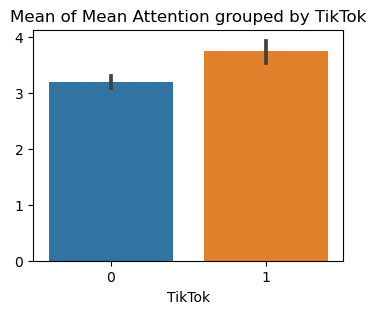


        Mean Attention
TikTok                
0             3.198105
1             3.744681
p-value: 0.0000; t-statistic: -4.4127



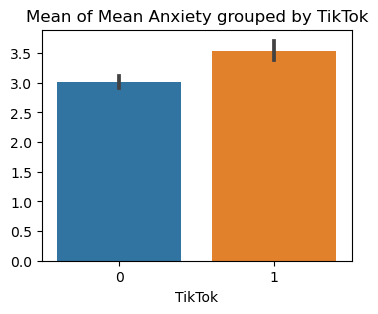


        Mean Anxiety
TikTok              
0           3.012920
1           3.542553
p-value: 0.0000; t-statistic: -4.9031



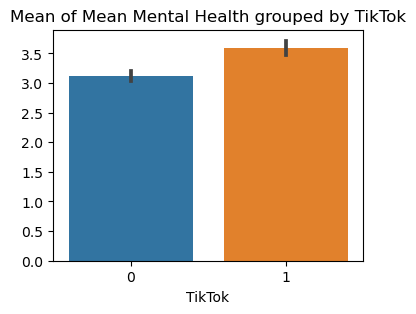


        Mean Mental Health
TikTok                    
0                 3.120586
1                 3.592199
p-value: 0.0000; t-statistic: -5.1701



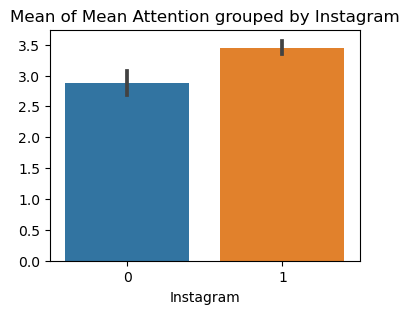


           Mean Attention
Instagram                
0                2.877049
1                3.450325
p-value: 0.0000; t-statistic: -5.1122



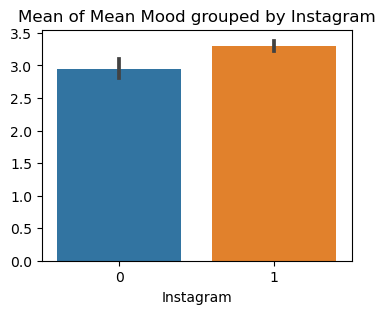


           Mean Mood
Instagram           
0           2.953552
1           3.306407
p-value: 0.0000; t-statistic: -4.2567



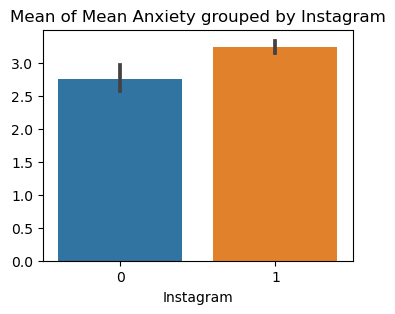


           Mean Anxiety
Instagram              
0              2.754098
1              3.239554
p-value: 0.0000; t-statistic: -4.9326



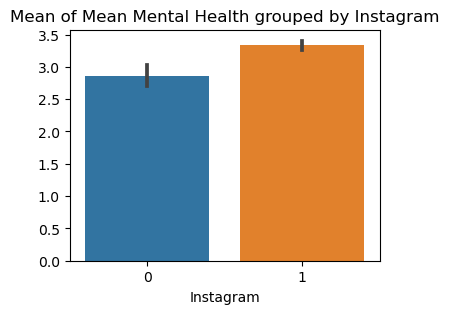


           Mean Mental Health
Instagram                    
0                    2.861566
1                    3.332095
p-value: 0.0000; t-statistic: -5.6915



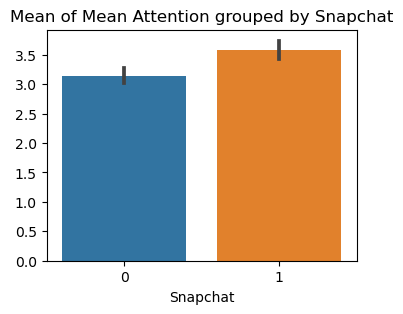


          Mean Attention
Snapchat                
0               3.142222
1               3.574586
p-value: 0.0000; t-statistic: -4.2590



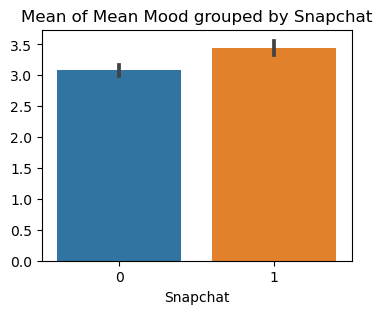


          Mean Mood
Snapchat           
0          3.080000
1          3.443831
p-value: 0.0000; t-statistic: -4.9168



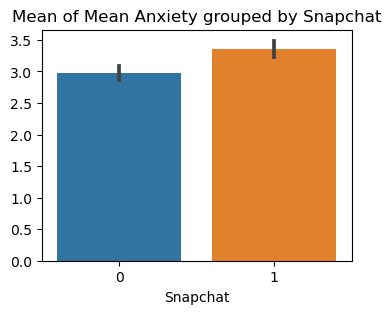


          Mean Anxiety
Snapchat              
0             2.970000
1             3.359116
p-value: 0.0000; t-statistic: -4.3797



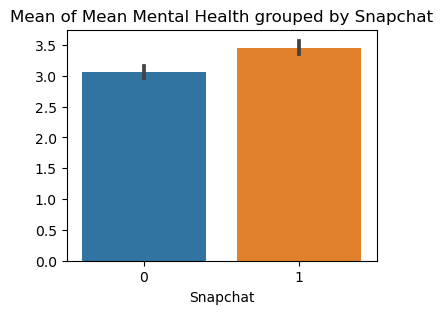


          Mean Mental Health
Snapchat                    
0                   3.064074
1                   3.459177
p-value: 0.0000; t-statistic: -5.2988



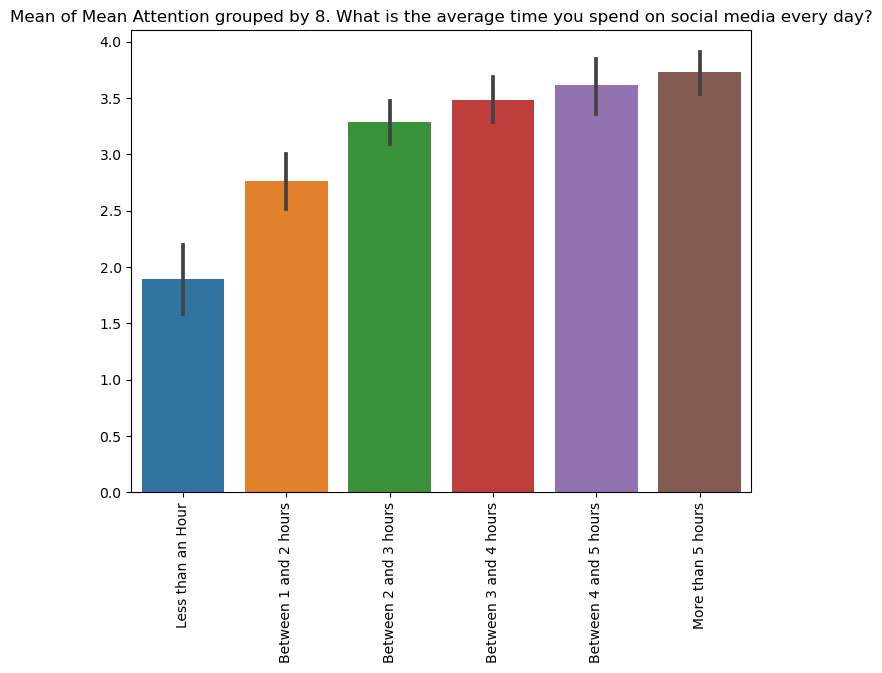


                                                    Mean Attention
8. What is the average time you spend on social...                
Less than an Hour                                         1.892157
Between 1 and 2 hours                                     2.766667
Between 2 and 3 hours                                     3.287129
Between 3 and 4 hours                                     3.487455
Between 4 and 5 hours                                     3.616915
More than 5 hours                                         3.732759



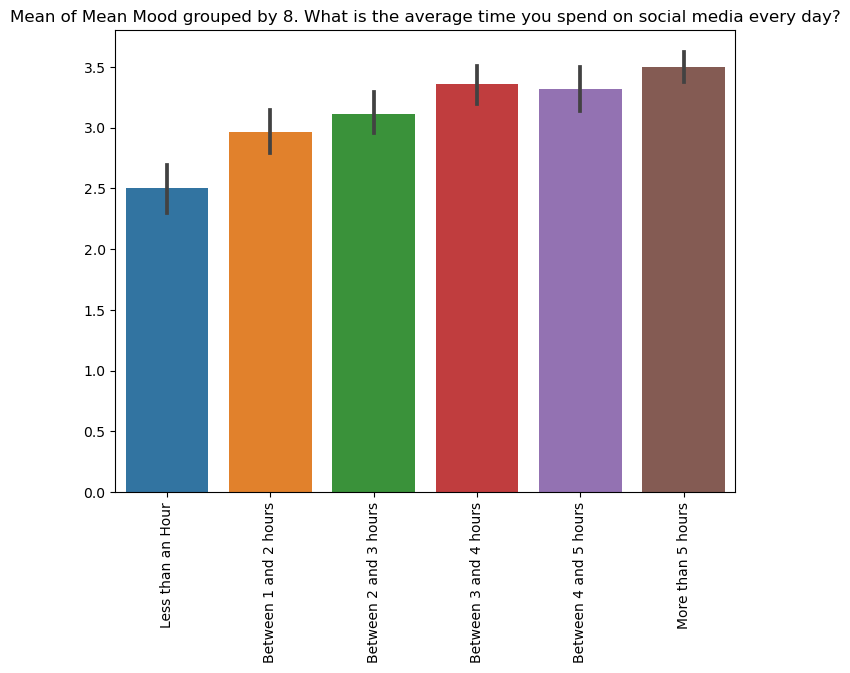


                                                    Mean Mood
8. What is the average time you spend on social...           
Less than an Hour                                    2.500000
Between 1 and 2 hours                                2.966667
Between 2 and 3 hours                                3.115512
Between 3 and 4 hours                                3.354839
Between 4 and 5 hours                                3.318408
More than 5 hours                                    3.497126



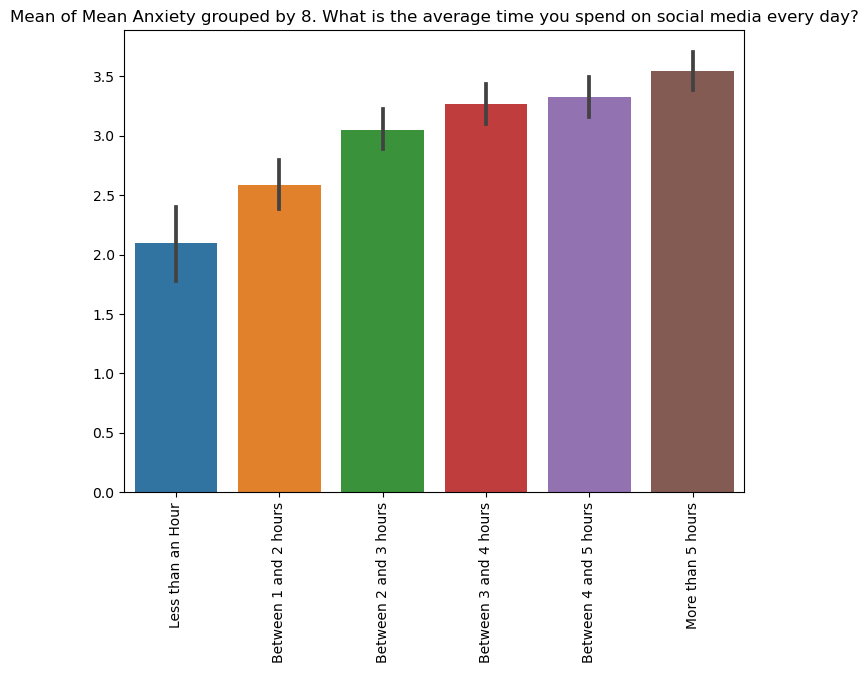


                                                    Mean Anxiety
8. What is the average time you spend on social...              
Less than an Hour                                       2.098039
Between 1 and 2 hours                                   2.585714
Between 2 and 3 hours                                   3.049505
Between 3 and 4 hours                                   3.268817
Between 4 and 5 hours                                   3.328358
More than 5 hours                                       3.548851



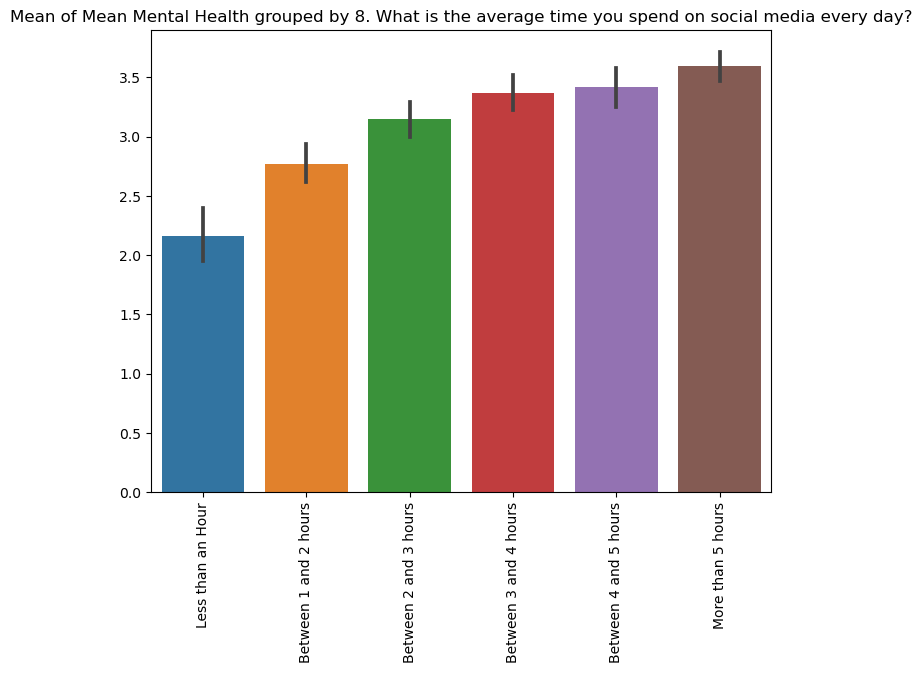


                                                    Mean Mental Health
8. What is the average time you spend on social...                    
Less than an Hour                                             2.163399
Between 1 and 2 hours                                         2.773016
Between 2 and 3 hours                                         3.150715
Between 3 and 4 hours                                         3.370370
Between 4 and 5 hours                                         3.421227
More than 5 hours                                             3.592912



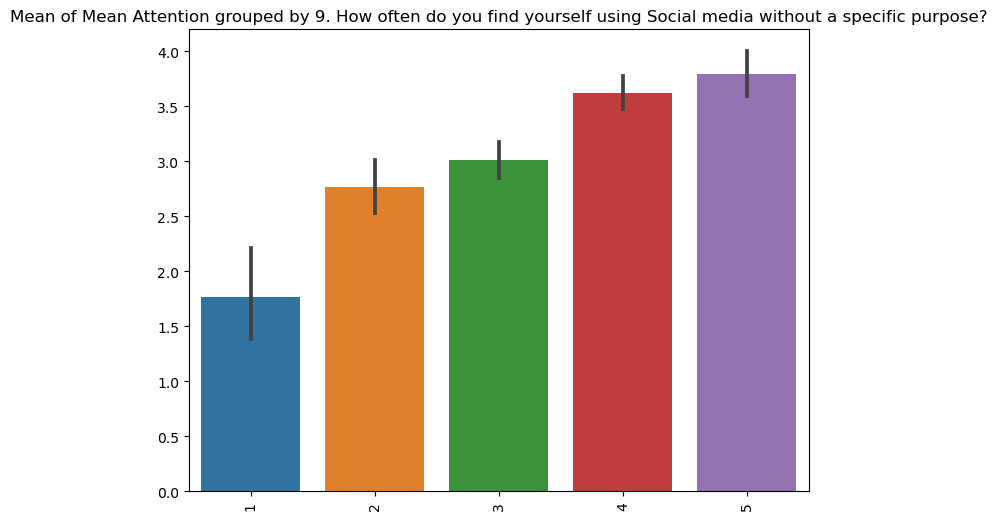


                                                    Mean Attention
9. How often do you find yourself using Social ...                
1                                                         1.766667
2                                                         2.764103
3                                                         3.012920
4                                                         3.625767
5                                                         3.798077



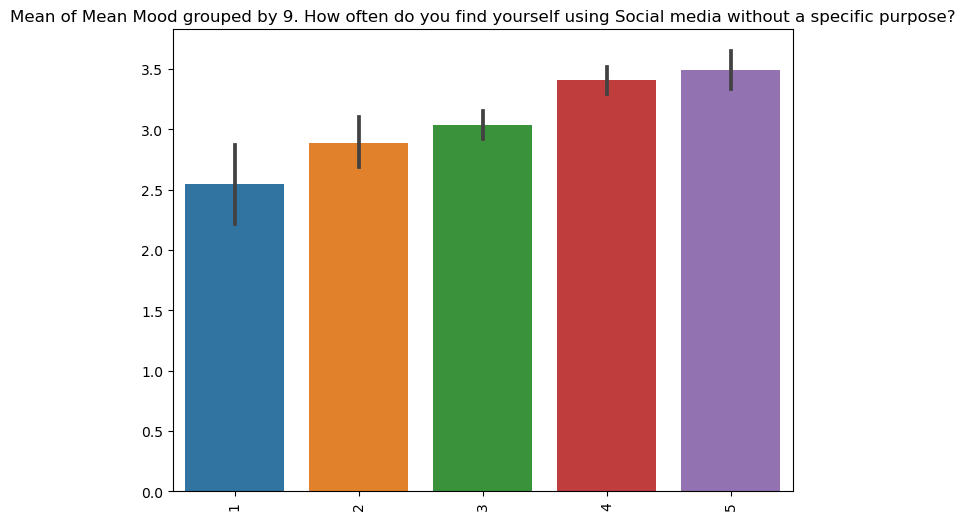


                                                    Mean Mood
9. How often do you find yourself using Social ...           
1                                                    2.550000
2                                                    2.882051
3                                                    3.031008
4                                                    3.406953
5                                                    3.487179



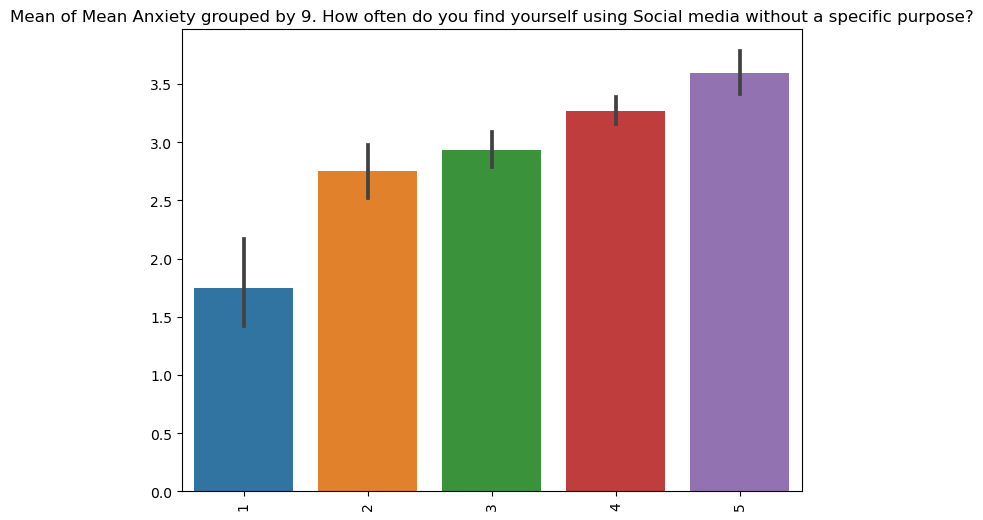


                                                    Mean Anxiety
9. How often do you find yourself using Social ...              
1                                                       1.750000
2                                                       2.748718
3                                                       2.935401
4                                                       3.269939
5                                                       3.592949



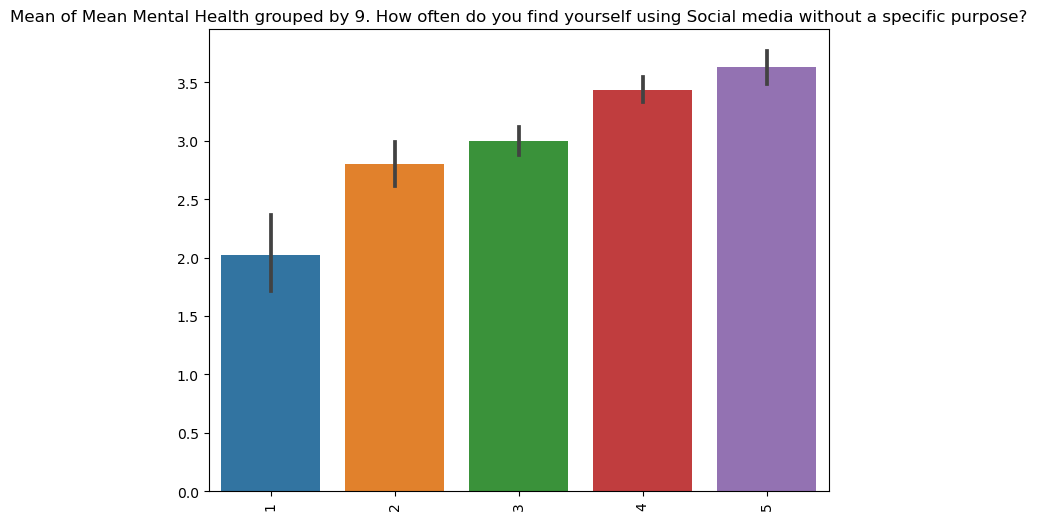


                                                    Mean Mental Health
9. How often do you find yourself using Social ...                    
1                                                             2.022222
2                                                             2.798291
3                                                             2.993109
4                                                             3.434219
5                                                             3.626068



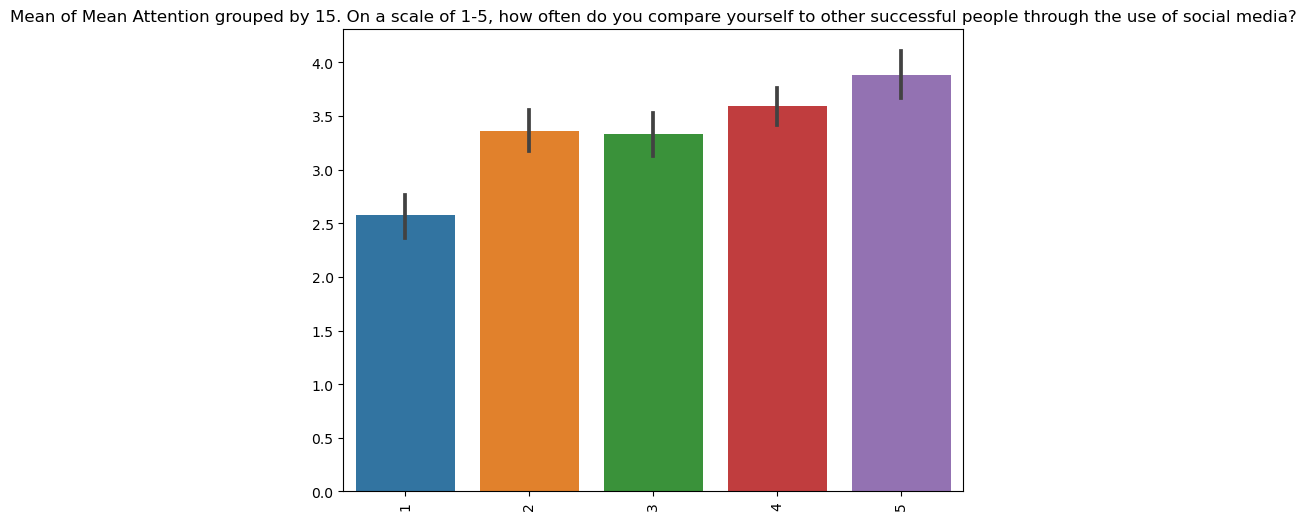


                                                    Mean Attention
15. On a scale of 1-5, how often do you compare...                
1                                                         2.575758
2                                                         3.364198
3                                                         3.330033
4                                                         3.588745
5                                                         3.886275



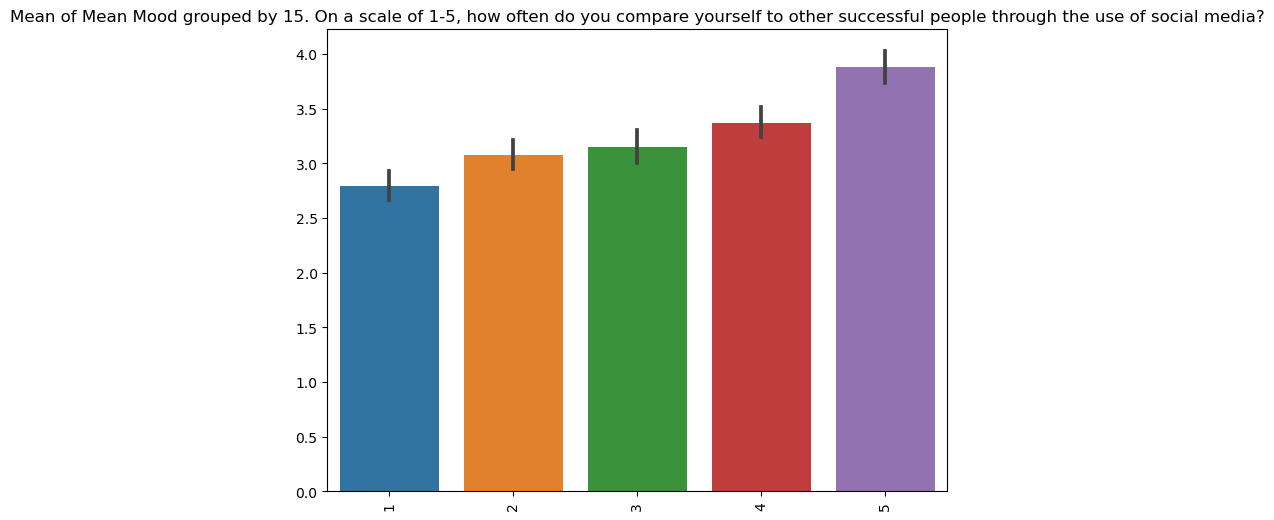


                                                    Mean Mood
15. On a scale of 1-5, how often do you compare...           
1                                                    2.796970
2                                                    3.077160
3                                                    3.148515
4                                                    3.367965
5                                                    3.882353



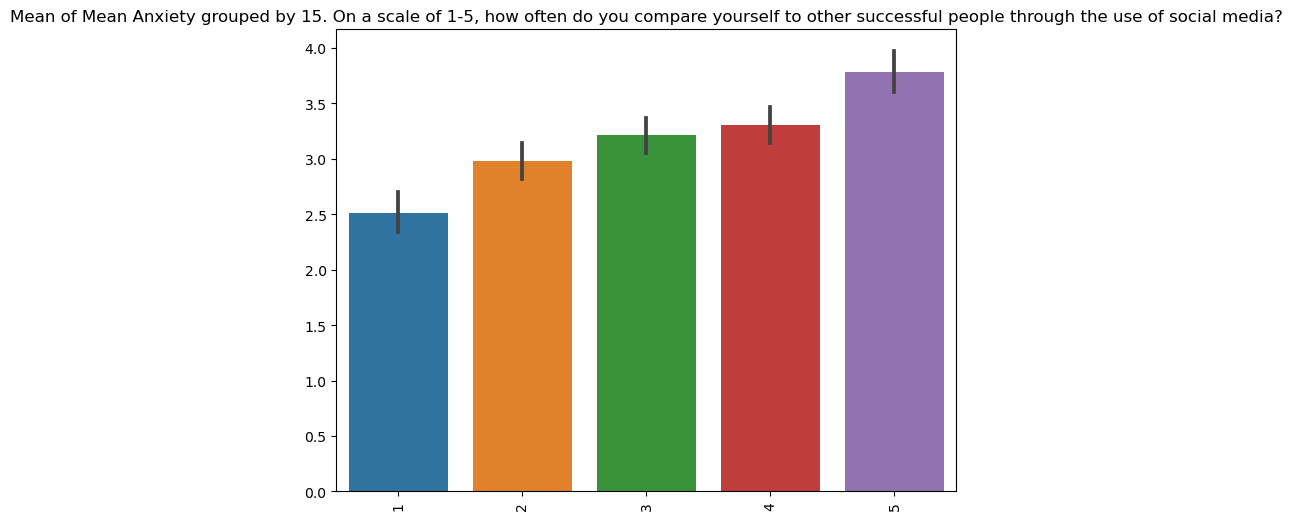


                                                    Mean Anxiety
15. On a scale of 1-5, how often do you compare...              
1                                                       2.515152
2                                                       2.978395
3                                                       3.217822
4                                                       3.303030
5                                                       3.780392



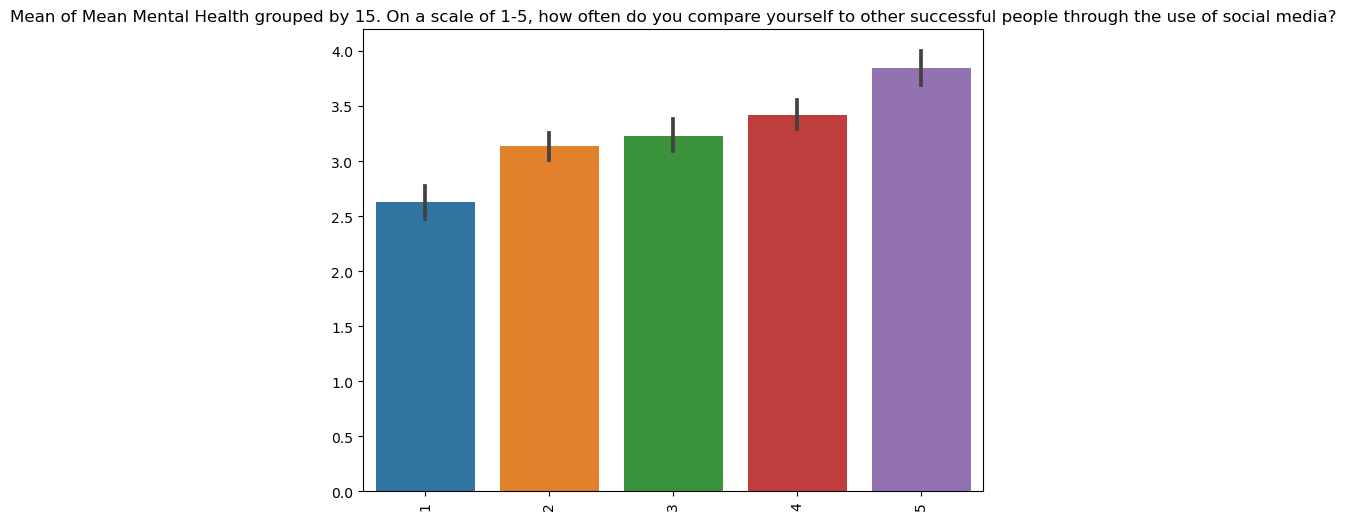


                                                    Mean Mental Health
15. On a scale of 1-5, how often do you compare...                    
1                                                             2.629293
2                                                             3.139918
3                                                             3.232123
4                                                             3.419913
5                                                             3.849673



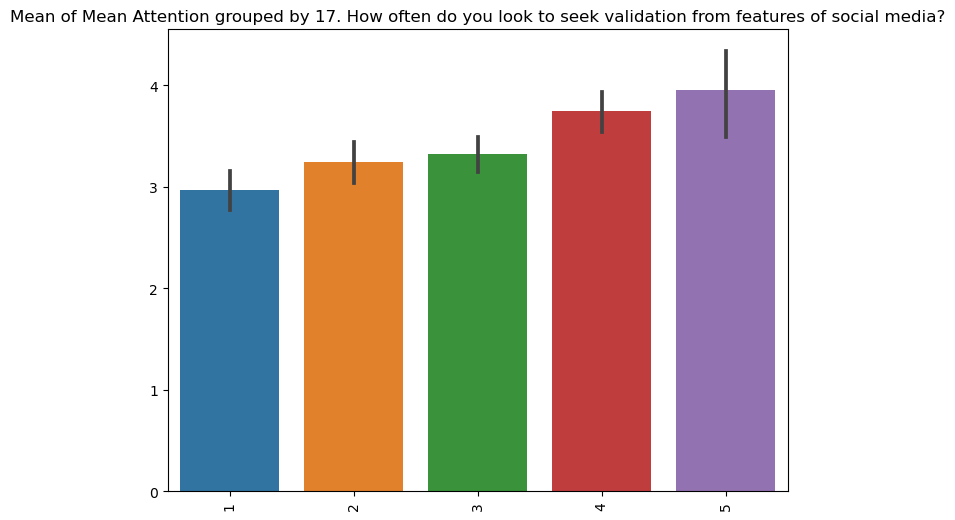


                                                    Mean Attention
17. How often do you look to seek validation fr...                
1                                                         2.971111
2                                                         3.245791
3                                                         3.322404
4                                                         3.742972
5                                                         3.950617



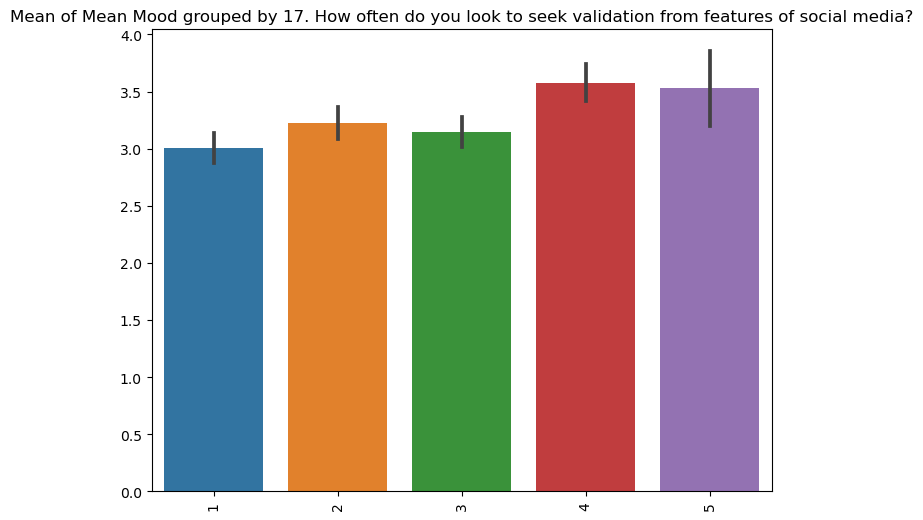


                                                    Mean Mood
17. How often do you look to seek validation fr...           
1                                                    3.006667
2                                                    3.228956
3                                                    3.150273
4                                                    3.578313
5                                                    3.530864



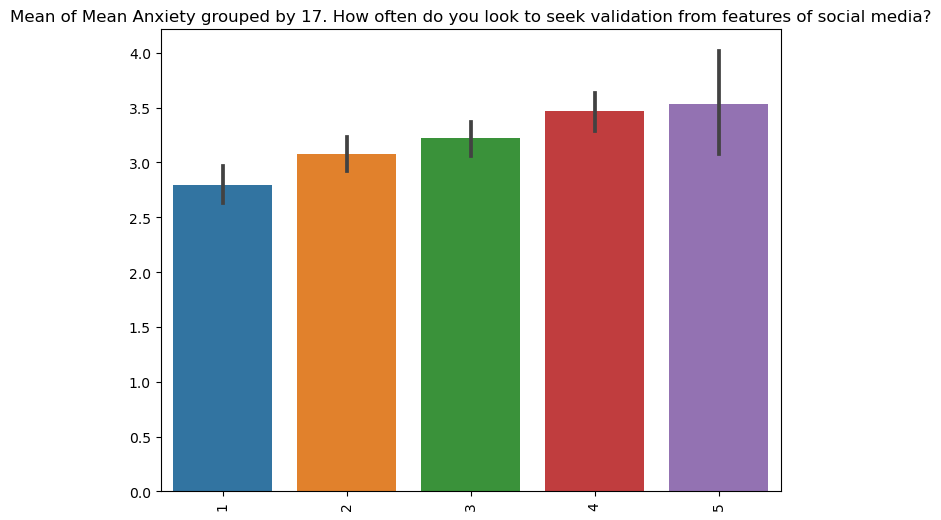


                                                    Mean Anxiety
17. How often do you look to seek validation fr...              
1                                                       2.791111
2                                                       3.077441
3                                                       3.218579
4                                                       3.465863
5                                                       3.530864



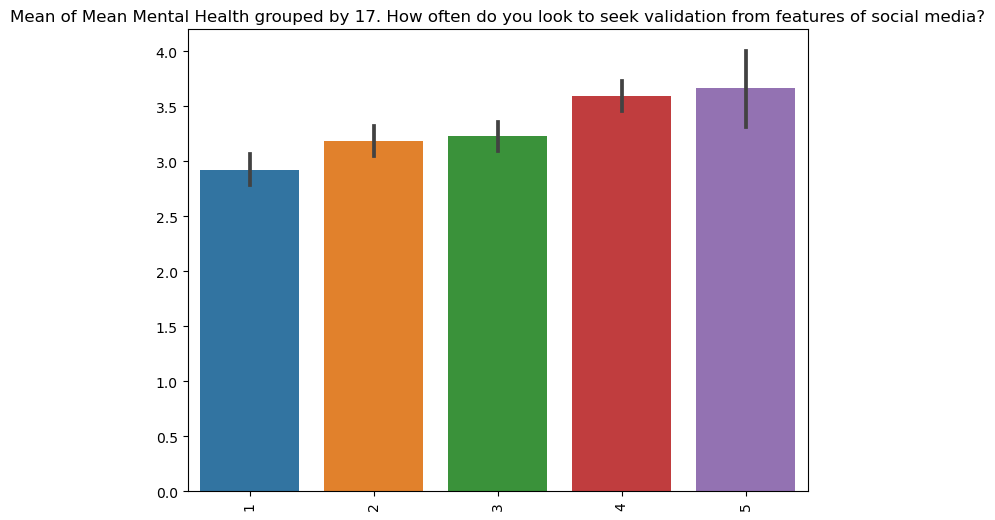


                                                    Mean Mental Health
17. How often do you look to seek validation fr...                    
1                                                             2.922963
2                                                             3.184063
3                                                             3.230419
4                                                             3.595716
5                                                             3.670782



In [9]:
groupby_cols = ['Male', 'Female', 'Married', 'In a relationship','Single', 'Student', 'Social Media','YouTube', 
                'Facebook', 'TikTok', 'Reddit', 'Twitter', 'Pinterest', 'Instagram', 'Snapchat', 'Discord', 
                'Number of Social Media Platforms', '8. What is the average time you spend on social media every day?',
                '9. How often do you find yourself using Social media without a specific purpose?', 
                '15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?', 
                '17. How often do you look to seek validation from features of social media?']

agg_cols = ['Mean Attention', 'Mean Mood', 'Mean Anxiety', 'Mean Mental Health']

for groupby_col in groupby_cols:
    for agg_col in agg_cols:
        if groupby_col not in (['8. What is the average time you spend on social media every day?',
                                '9. How often do you find yourself using Social media without a specific purpose?',
                                '15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?',
                                '17. How often do you look to seek validation from features of social media?']):
            get_mean_by_group_t_test(data, groupby_col, agg_col)
        else:
            get_mean_by_group(data, groupby_col, agg_col)

A few things are apparent from these tests. Males tend to score better on Mood (lower score indicates better mood) than other genders (primarily females). Married people tend to have better attention, less anxiety, and better moods than non-married people and students tend to have worse attention, more anxiety, and worse moods than non-students. 

Users of TikTok, Instagram, and Snapchat have the worst mental health compared to people who don't use the platform. TikTok users have worse attention and more anxiety; Instagram users have worse attention, more anxiety, and worse moods; and Snapchat users follow a similar pattern as Instagram users.

All three measures of mental health tend to be negatively correlated with the amount of time spent on social media per day. Using social media without a specific purpose, comparing yourself to other successful people through social media, and seeking validation from features of social media also appear to have negative correlations with all three aspects of mood.

# Bar charts for significant findings - social media usage

In [10]:
value_mapping = {
    'Less than an Hour': 0,
    'Between 1 and 2 hours': 1,
    'Between 2 and 3 hours': 2,
    'Between 3 and 4 hours': 3,
    'Between 4 and 5 hours': 4,
    'More than 5 hours': 5
}

data['8. What is the average time you spend on social media every day?'] = data['8. What is the average time you spend on social media every day?'].replace(value_mapping)

data['8. What is the average time you spend on social media every day?'] = data['8. What is the average time you spend on social media every day?'].astype(float)

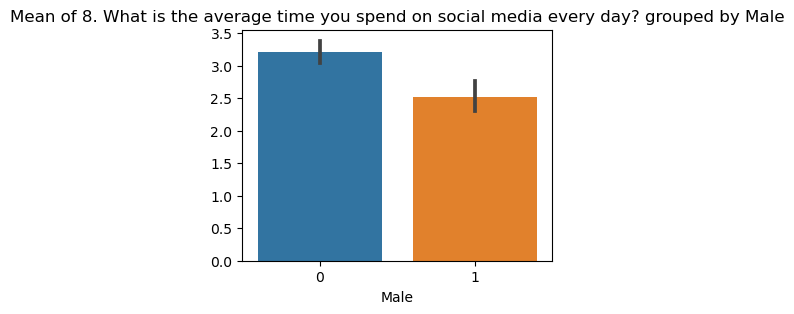


      8. What is the average time you spend on social media every day?
Male                                                                  
0                                              3.207407               
1                                              2.526066               
p-value: 0.0000; t-statistic: 4.7670



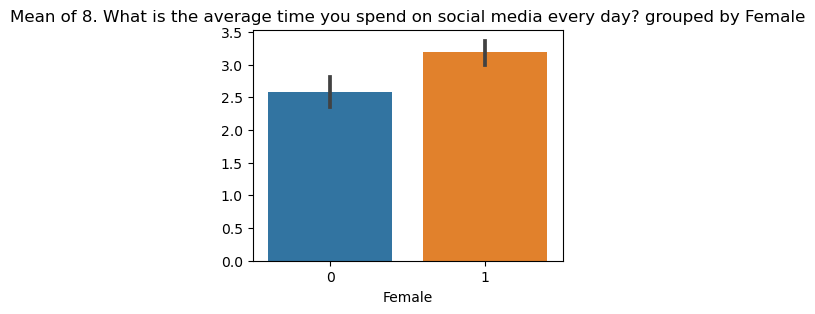


        8. What is the average time you spend on social media every day?
Female                                                                  
0                                                2.573394               
1                                                3.186312               
p-value: 0.0000; t-statistic: -4.2831



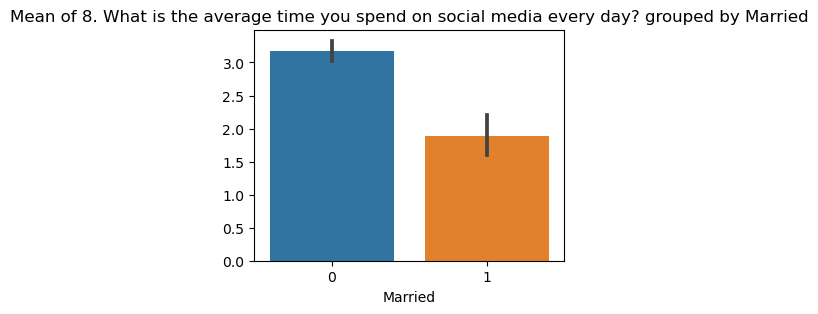


         8. What is the average time you spend on social media every day?
Married                                                                  
0                                                 3.178947               
1                                                 1.891089               
p-value: 0.0000; t-statistic: 7.6555



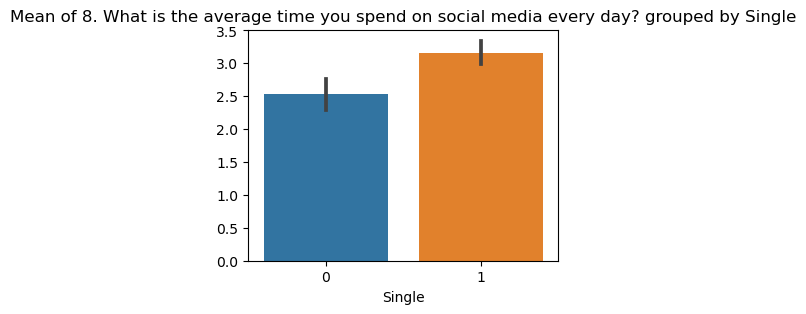


        8. What is the average time you spend on social media every day?
Single                                                                  
0                                                2.535714               
1                                                3.164912               
p-value: 0.0000; t-statistic: -4.3422



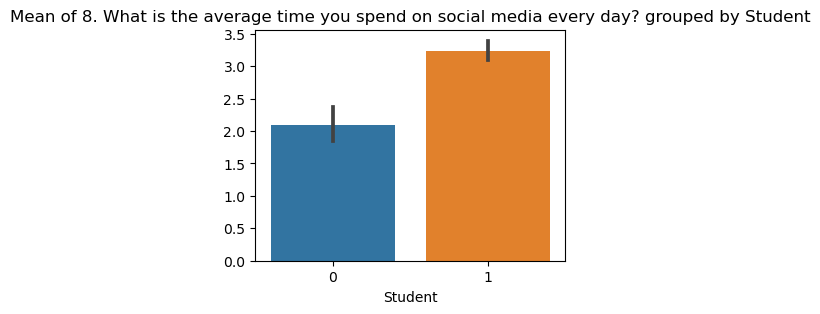


         8. What is the average time you spend on social media every day?
Student                                                                  
0                                                 2.100000               
1                                                 3.240469               
p-value: 0.0000; t-statistic: -7.5497



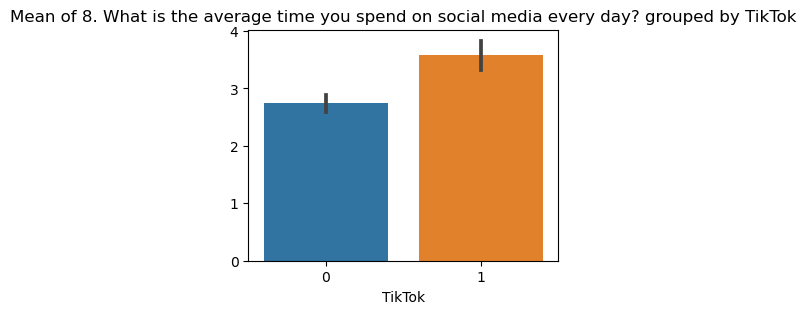


        8. What is the average time you spend on social media every day?
TikTok                                                                  
0                                                2.744186               
1                                                3.585106               
p-value: 0.0000; t-statistic: -4.6984



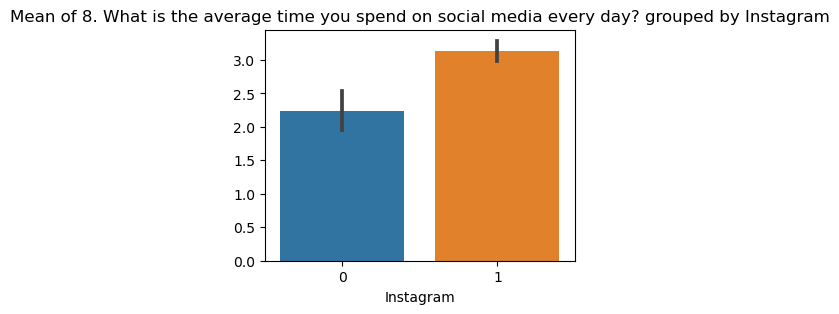


           8. What is the average time you spend on social media every day?
Instagram                                                                  
0                                                   2.237705               
1                                                   3.136490               
p-value: 0.0000; t-statistic: -5.5584



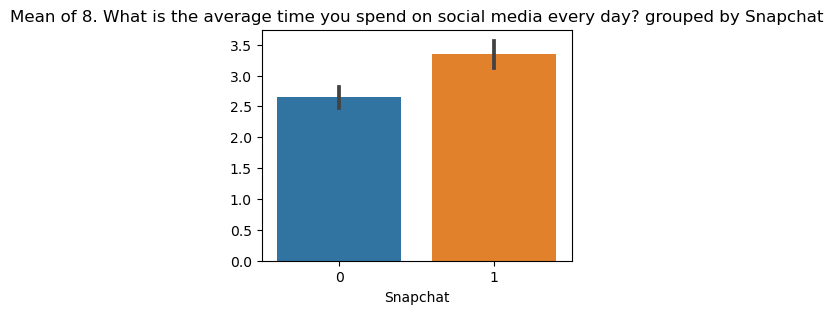


          8. What is the average time you spend on social media every day?
Snapchat                                                                  
0                                                  2.646667               
1                                                  3.342541               
p-value: 0.0000; t-statistic: -4.7525



In [11]:
groupby_cols.remove('8. What is the average time you spend on social media every day?')
for groupby_col in groupby_cols:
    get_mean_by_group_t_test(data, groupby_col, '8. What is the average time you spend on social media every day?')

The tests regarding social media usage revealed that males spend significantly less time on social media per day than other people (mostly females), as do married people. Students, TikTok users, Instagram users, and Snapchat users spend significantly more time on these platforms.

# Summary of t-test findings

Taken together, we observe that males tend to spend less time on social media than other genders and tend to report better moods. Married people tend to spend less time on social media than unmarried people and tend to have better attention, less anxiety, and better moods. Students tend to spend more time on social media than non-students and tend to have worse attention, more anxiety, and worse moods.

TikTok, Instagram, and Snapchat users also tend to spend more time on social media and have worse mental health compared to people who don't use the platforms. TikTok users have worse attention and more anxiety; Instagram users have worse attention, more anxiety, and worse moods; and Snapchat users follow a similar pattern as Instagram users.

Since all three measures of mental health appear to be negatively correlated with the amount of time spent on social media per day, and it appears that the populations that use it the most have the worst mental health (women, unmarried people, students, and users of TikTok, Instagram, and Snapchat), it seems there is a definite link between using social media (in particular TikTok, Instagram, and Snapchat) and having worse mental health. People who use social media without a specific purpose, compare themselves to other successful people through social media, and seek validation from the features of social media appear affected, as well.

# Eliminate redundant features

In [12]:
data = pd.DataFrame(data[['1. What is your age?', 'Male', 'Married', 'Student',
       'YouTube', 'Facebook', 'TikTok', 'Reddit', 'Twitter', 'Pinterest',
       'Instagram', 'Snapchat', 'Discord', 'Number of Social Media Platforms',
       '8. What is the average time you spend on social media every day?',
       '9. How often do you find yourself using Social media without a specific purpose?',  
       '15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?',
       '17. How often do you look to seek validation from features of social media?',
       'Mean Attention', 'Mean Mood', 'Mean Anxiety', 'Mean Mental Health'
       ]])

# Correlation heatmap

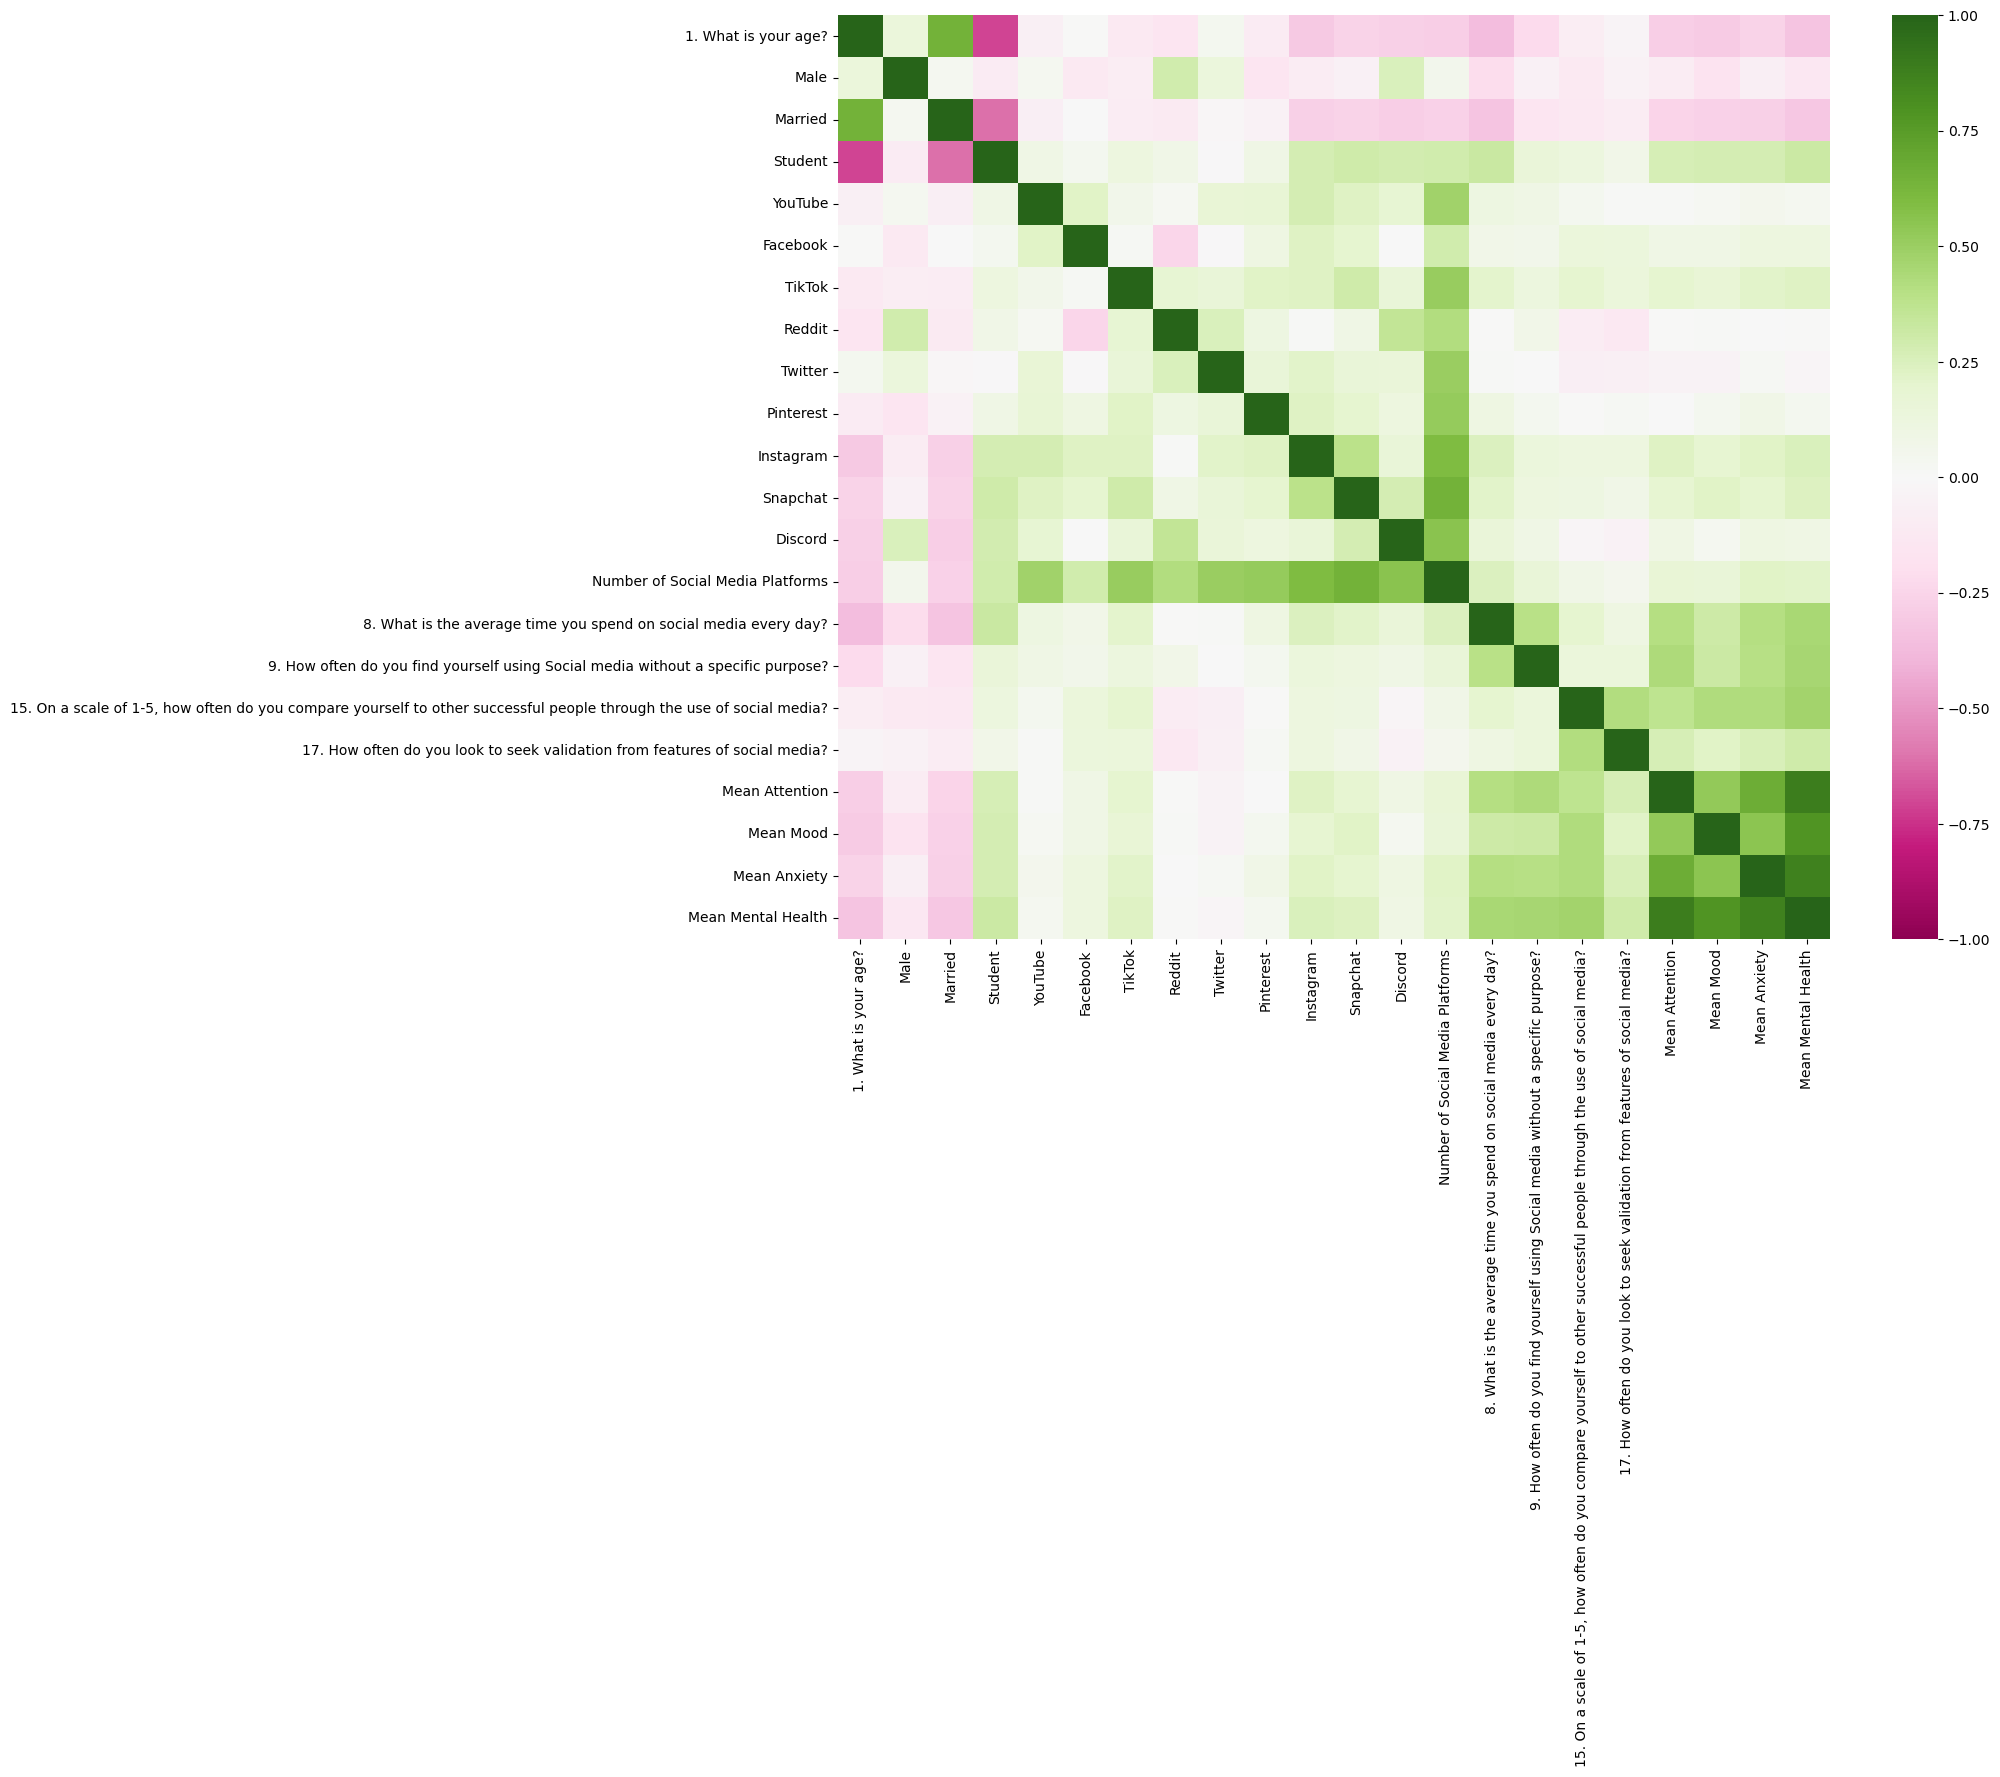

In [13]:
plt.figure(figsize=(16, 12))
sns.heatmap(data[['1. What is your age?', 'Male', 'Married', 'Student',
                  'YouTube', 'Facebook', 'TikTok', 'Reddit', 'Twitter', 'Pinterest',
                  'Instagram', 'Snapchat', 'Discord', 'Number of Social Media Platforms',
                  '8. What is the average time you spend on social media every day?',
                  '9. How often do you find yourself using Social media without a specific purpose?',
                  '15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?',
                  '17. How often do you look to seek validation from features of social media?',
                  'Mean Attention', 'Mean Mood', 'Mean Anxiety', 'Mean Mental Health'
       ]].corr(),
            vmin=-1, vmax=1,cmap='PiYG');

# Train-test split

In [14]:
X_train_attention, X_test_attention, y_train_attention, y_test_attention = train_test_split(data.drop(columns=['Mean Attention', 
                                                                                                               'Mean Mood', 
                                                                                                               'Mean Anxiety', 
                                                                                                               'Mean Mental Health']), 
                                                    data['Mean Attention'], test_size=0.2, random_state=47)

X_train_mood, X_test_mood, y_train_mood, y_test_mood = train_test_split(data.drop(columns=['Mean Attention', 'Mean Mood', 
                                                                                           'Mean Anxiety', 
                                                                                           'Mean Mental Health']),
                                                                        data['Mean Mood'], test_size=0.2, random_state=47)

X_train_anxiety, X_test_anxiety, y_train_anxiety, y_test_anxiety = train_test_split(data.drop(columns=['Mean Attention', 
                                                                                                       'Mean Mood', 
                                                                                                       'Mean Anxiety', 
                                                                                                       'Mean Mental Health']),
                                                                                    data['Mean Anxiety'], test_size=0.2, random_state=47)

X_train_mental_health, X_test_mental_health, y_train_mental_health, y_test_mental_health = train_test_split(
    data.drop(columns=['Mean Attention', 'Mean Mood', 'Mean Anxiety', 'Mean Mental Health']),
    data['Mean Mental Health'], test_size=0.2, random_state=47)

# Attention

### Linear Regression

In [15]:
pipe_lin_reg_attention = make_pipeline(
    SimpleImputer(), 
    StandardScaler(),
    PolynomialFeatures(),
    SelectKBest(),
    LinearRegression()
)

In [16]:
grid_params_lr = {
        'simpleimputer__strategy': ['mean', 'median'],
        'standardscaler': [StandardScaler(), MinMaxScaler(), None],
        'polynomialfeatures__degree': [1, 2],
        'polynomialfeatures__include_bias': [True, False],
        'polynomialfeatures__interaction_only': [True, False],
        'selectkbest__k': [4, 5, 6, 7, 8, 9, 10, 11, 12, 'all'],
        'selectkbest__score_func': [f_regression, mutual_info_regression],
        'linearregression__fit_intercept': [True, False]
}

In [17]:
warnings.filterwarnings("ignore")
lr_attention_grid_cv = GridSearchCV(pipe_lin_reg_attention, param_grid=grid_params_lr, cv=5, n_jobs=-1)
lr_attention_grid_cv.fit(X_train_attention, y_train_attention)
print(lr_attention_grid_cv.best_params_)
print(f'Best Score = {lr_attention_grid_cv.best_score_}')
warnings.resetwarnings()

{'linearregression__fit_intercept': True, 'polynomialfeatures__degree': 2, 'polynomialfeatures__include_bias': True, 'polynomialfeatures__interaction_only': True, 'selectkbest__k': 4, 'selectkbest__score_func': <function f_regression at 0x000001F0B59B0940>, 'simpleimputer__strategy': 'mean', 'standardscaler': StandardScaler()}
Best Score = 0.3194559441443623


In [18]:
selected = lr_attention_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = lr_attention_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = lr_attention_grid_cv.best_estimator_.named_steps.polynomialfeatures.get_feature_names_out(
    input_features=X_train_attention.columns)[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

9. How often do you find yourself using Social media without a specific purpose?                                        0.341876
15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?    0.289911
1. What is your age? Student                                                                                            0.166208
8. What is the average time you spend on social media every day?                                                        0.150705
dtype: float64

### Random Forest

In [19]:
pipe_RF_attention = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

In [20]:
grid_params_rf = {
        'simpleimputer__strategy': ['mean', 'median'],
        'standardscaler': [StandardScaler(), MinMaxScaler(), None],
        'randomforestregressor__bootstrap': [True, False],
        'randomforestregressor__ccp_alpha': [.0001, .001, .01, .1],
        'randomforestregressor__criterion': ["squared_error", "absolute_error", "friedman_mse", "poisson"],
        'randomforestregressor__max_depth': [3, 5, 10, 20, None],
        'randomforestregressor__max_features': ["sqrt", "log2", None],
        'randomforestregressor__max_leaf_nodes':[10, 20, 50, 100, 200, None],
        'randomforestregressor__min_impurity_decrease': [0, .0001, .001, .01, .1],
        'randomforestregressor__min_samples_leaf': [1, 2, 3, 4, 5],
        'randomforestregressor__n_estimators': [100, 200, 300, 400, 500],
        'randomforestregressor__n_jobs': [-1],
        'randomforestregressor__warm_start': [True, False]
}

In [21]:
warnings.filterwarnings("ignore")
RF_attention_grid_cv = RandomizedSearchCV(pipe_RF_attention, param_distributions=grid_params_rf, 
                                               cv=5, n_jobs=-1, n_iter = 300)
RF_attention_grid_cv.fit(X_train_attention, y_train_attention)
print(RF_attention_grid_cv.best_params_)
print(f'Best Score = {RF_attention_grid_cv.best_score_}')
warnings.resetwarnings()

{'standardscaler': MinMaxScaler(), 'simpleimputer__strategy': 'mean', 'randomforestregressor__warm_start': True, 'randomforestregressor__n_jobs': -1, 'randomforestregressor__n_estimators': 500, 'randomforestregressor__min_samples_leaf': 5, 'randomforestregressor__min_impurity_decrease': 0, 'randomforestregressor__max_leaf_nodes': 100, 'randomforestregressor__max_features': 'log2', 'randomforestregressor__max_depth': 5, 'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__ccp_alpha': 0.0001, 'randomforestregressor__bootstrap': True}
Best Score = 0.27086408307530063


In [22]:
features = RF_attention_grid_cv.best_estimator_[:-1].get_feature_names_out()
feature_importances = RF_attention_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
pd.Series(feature_importances, index=features).sort_values(ascending=False)

9. How often do you find yourself using Social media without a specific purpose?                                        0.224267
15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?    0.171100
1. What is your age?                                                                                                    0.149741
8. What is the average time you spend on social media every day?                                                        0.146844
17. How often do you look to seek validation from features of social media?                                             0.073407
Student                                                                                                                 0.038465
Number of Social Media Platforms                                                                                        0.038403
Married                                                                                          

# Mood

### Linear Regression

In [23]:
pipe_lin_reg_mood = make_pipeline(
    SimpleImputer(), 
    StandardScaler(),
    PolynomialFeatures(),
    SelectKBest(),
    LinearRegression()
)

In [24]:
warnings.filterwarnings("ignore")
lr_mood_grid_cv = GridSearchCV(pipe_lin_reg_mood, param_grid=grid_params_lr, cv=5, n_jobs=-1)
lr_mood_grid_cv.fit(X_train_mood, y_train_mood)
print(lr_mood_grid_cv.best_params_)
print(f'Best Score = {lr_mood_grid_cv.best_score_}')
warnings.resetwarnings()

{'linearregression__fit_intercept': True, 'polynomialfeatures__degree': 2, 'polynomialfeatures__include_bias': True, 'polynomialfeatures__interaction_only': False, 'selectkbest__k': 10, 'selectkbest__score_func': <function f_regression at 0x000001F0B59B0940>, 'simpleimputer__strategy': 'mean', 'standardscaler': StandardScaler()}
Best Score = 0.32447561323455654


In [25]:
selected = lr_mood_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = lr_mood_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = lr_mood_grid_cv.best_estimator_.named_steps.polynomialfeatures.get_feature_names_out(
    input_features=X_train_mood.columns)[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

Married^2                                                                                                               2.730119e+12
15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?    2.823792e-01
1. What is your age? Student                                                                                            1.831055e-01
9. How often do you find yourself using Social media without a specific purpose?                                        1.669922e-01
8. What is the average time you spend on social media every day?                                                        6.317139e-02
1. What is your age?                                                                                                    4.979874e-02
Married Student                                                                                                         4.858398e-02
Student                                                              

### Random Forest

In [26]:
pipe_RF_mood = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

In [27]:
warnings.filterwarnings("ignore")
RF_mood_grid_cv = RandomizedSearchCV(pipe_RF_mood, param_distributions=grid_params_rf, 
                                               cv=5, n_jobs=-1, n_iter = 300)
RF_mood_grid_cv.fit(X_train_mood, y_train_mood)
print(RF_mood_grid_cv.best_params_)
print(f'Best Score = {RF_mood_grid_cv.best_score_}')
warnings.resetwarnings()

{'standardscaler': StandardScaler(), 'simpleimputer__strategy': 'mean', 'randomforestregressor__warm_start': False, 'randomforestregressor__n_jobs': -1, 'randomforestregressor__n_estimators': 200, 'randomforestregressor__min_samples_leaf': 4, 'randomforestregressor__min_impurity_decrease': 0.001, 'randomforestregressor__max_leaf_nodes': 10, 'randomforestregressor__max_features': None, 'randomforestregressor__max_depth': 5, 'randomforestregressor__criterion': 'absolute_error', 'randomforestregressor__ccp_alpha': 0.01, 'randomforestregressor__bootstrap': True}
Best Score = 0.27087428818508524


In [28]:
features = RF_mood_grid_cv.best_estimator_[:-1].get_feature_names_out()
feature_importances = RF_mood_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
pd.Series(feature_importances, index=features).sort_values(ascending=False)

15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?    0.333890
1. What is your age?                                                                                                    0.235326
9. How often do you find yourself using Social media without a specific purpose?                                        0.178306
8. What is the average time you spend on social media every day?                                                        0.092682
17. How often do you look to seek validation from features of social media?                                             0.047794
Male                                                                                                                    0.030376
Number of Social Media Platforms                                                                                        0.017392
Married                                                                                          

# Anxiety

### Linear Regression

In [29]:
pipe_lin_reg_anxiety = make_pipeline(
    SimpleImputer(), 
    StandardScaler(),
    PolynomialFeatures(),
    SelectKBest(),
    LinearRegression()
)

In [30]:
warnings.filterwarnings("ignore")
lr_anxiety_grid_cv = GridSearchCV(pipe_lin_reg_anxiety, param_grid=grid_params_lr, cv=5, n_jobs=-1)
lr_anxiety_grid_cv.fit(X_train_anxiety, y_train_anxiety)
print(lr_anxiety_grid_cv.best_params_)
print(f'Best Score = {lr_anxiety_grid_cv.best_score_}')
warnings.resetwarnings()

{'linearregression__fit_intercept': True, 'polynomialfeatures__degree': 1, 'polynomialfeatures__include_bias': True, 'polynomialfeatures__interaction_only': False, 'selectkbest__k': 6, 'selectkbest__score_func': <function mutual_info_regression at 0x000001F0B5992B00>, 'simpleimputer__strategy': 'mean', 'standardscaler': None}
Best Score = 0.3679410798367891


In [31]:
selected = lr_anxiety_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = lr_anxiety_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = lr_anxiety_grid_cv.best_estimator_.named_steps.polynomialfeatures.get_feature_names_out(
    input_features=X_train_anxiety.columns)[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

Student                                                                                                                 0.275107
15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?    0.242259
9. How often do you find yourself using Social media without a specific purpose?                                        0.231684
8. What is the average time you spend on social media every day?                                                        0.102579
Male                                                                                                                    0.072289
Married                                                                                                                -0.164093
dtype: float64

### Random Forest

In [32]:
pipe_RF_anxiety = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

In [33]:
warnings.filterwarnings("ignore")
RF_anxiety_grid_cv = RandomizedSearchCV(pipe_RF_anxiety, param_distributions=grid_params_rf, 
                                               cv=5, n_jobs=-1, n_iter = 300)
RF_anxiety_grid_cv.fit(X_train_anxiety, y_train_anxiety)
print(RF_anxiety_grid_cv.best_params_)
print(f'Best Score = {RF_anxiety_grid_cv.best_score_}')
warnings.resetwarnings()

{'standardscaler': MinMaxScaler(), 'simpleimputer__strategy': 'median', 'randomforestregressor__warm_start': False, 'randomforestregressor__n_jobs': -1, 'randomforestregressor__n_estimators': 300, 'randomforestregressor__min_samples_leaf': 3, 'randomforestregressor__min_impurity_decrease': 0, 'randomforestregressor__max_leaf_nodes': 50, 'randomforestregressor__max_features': 'log2', 'randomforestregressor__max_depth': 10, 'randomforestregressor__criterion': 'absolute_error', 'randomforestregressor__ccp_alpha': 0.001, 'randomforestregressor__bootstrap': True}
Best Score = 0.305736687447599


In [34]:
features = RF_anxiety_grid_cv.best_estimator_[:-1].get_feature_names_out()
feature_importances = RF_anxiety_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
pd.Series(feature_importances, index=features).sort_values(ascending=False)

15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?    0.178713
9. How often do you find yourself using Social media without a specific purpose?                                        0.150064
1. What is your age?                                                                                                    0.130185
8. What is the average time you spend on social media every day?                                                        0.128277
17. How often do you look to seek validation from features of social media?                                             0.081931
Number of Social Media Platforms                                                                                        0.075995
Married                                                                                                                 0.036496
Instagram                                                                                        

# Overall mental health

### Linear Regression

In [35]:
pipe_lin_reg_mental_health = make_pipeline(
    SimpleImputer(), 
    StandardScaler(),
    PolynomialFeatures(),
    SelectKBest(),
    LinearRegression()
)

In [36]:
warnings.filterwarnings("ignore")
lr_mh_grid_cv = GridSearchCV(pipe_lin_reg_mental_health, param_grid=grid_params_lr, cv=5, n_jobs=-1)
lr_mh_grid_cv.fit(X_train_mental_health, y_train_mental_health)
print(lr_mh_grid_cv.best_params_)
print(f'Best Score = {lr_mh_grid_cv.best_score_}')
warnings.resetwarnings()

{'linearregression__fit_intercept': True, 'polynomialfeatures__degree': 2, 'polynomialfeatures__include_bias': True, 'polynomialfeatures__interaction_only': True, 'selectkbest__k': 4, 'selectkbest__score_func': <function f_regression at 0x000001F0B59B0940>, 'simpleimputer__strategy': 'mean', 'standardscaler': StandardScaler()}
Best Score = 0.4707203190199273


In [37]:
selected = lr_mh_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = lr_mh_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = lr_mh_grid_cv.best_estimator_.named_steps.polynomialfeatures.get_feature_names_out(
    input_features=X_train_mental_health.columns)[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?    0.305482
9. How often do you find yourself using Social media without a specific purpose?                                        0.252684
1. What is your age? Student                                                                                            0.156044
8. What is the average time you spend on social media every day?                                                        0.129638
dtype: float64

### Random Forest

In [38]:
pipe_RF_mental_health = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

In [39]:
warnings.filterwarnings("ignore")
RF_mh_grid_cv = RandomizedSearchCV(pipe_RF_mental_health, param_distributions=grid_params_rf, 
                                               cv=5, n_jobs=-1, n_iter = 300)
RF_mh_grid_cv.fit(X_train_mood, y_train_mood)
print(RF_mh_grid_cv.best_params_)
print(f'Best Score = {RF_mh_grid_cv.best_score_}')
warnings.resetwarnings()

{'standardscaler': StandardScaler(), 'simpleimputer__strategy': 'mean', 'randomforestregressor__warm_start': True, 'randomforestregressor__n_jobs': -1, 'randomforestregressor__n_estimators': 200, 'randomforestregressor__min_samples_leaf': 4, 'randomforestregressor__min_impurity_decrease': 0, 'randomforestregressor__max_leaf_nodes': 20, 'randomforestregressor__max_features': None, 'randomforestregressor__max_depth': 20, 'randomforestregressor__criterion': 'absolute_error', 'randomforestregressor__ccp_alpha': 0.01, 'randomforestregressor__bootstrap': True}
Best Score = 0.26878102117233754


In [40]:
features = RF_mh_grid_cv.best_estimator_[:-1].get_feature_names_out()
feature_importances = RF_mh_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
pd.Series(feature_importances, index=features).sort_values(ascending=False)

15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?    0.324481
1. What is your age?                                                                                                    0.232633
9. How often do you find yourself using Social media without a specific purpose?                                        0.178318
8. What is the average time you spend on social media every day?                                                        0.092743
17. How often do you look to seek validation from features of social media?                                             0.052128
Male                                                                                                                    0.031493
Number of Social Media Platforms                                                                                        0.019422
Married                                                                                          

# Final model selection

### Attention

#### Linear Regression

In [41]:
lr_attention_neg_mae = cross_validate(lr_attention_grid_cv.best_estimator_, X_train_attention, 
                                      y_train_attention, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [42]:
lr_attention_mae_mean = np.mean(-1 * lr_attention_neg_mae['test_score'])
lr_attention_mae_std = np.std(-1 * lr_attention_neg_mae['test_score'])
lr_attention_mae_mean, lr_attention_mae_std

(0.7289277289784731, 0.06409183795255907)

In [43]:
mean_absolute_error(y_test_attention, lr_attention_grid_cv.best_estimator_.predict(X_test_attention))

0.7062456419736319

#### Random Forest

In [44]:
rf_attention_neg_mae = cross_validate(RF_attention_grid_cv.best_estimator_, X_train_attention, y_train_attention, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [45]:
rf_attention_mae_mean = np.mean(-1 * rf_attention_neg_mae['test_score'])
rf_attention_mae_std = np.std(-1 * rf_attention_neg_mae['test_score'])
rf_attention_mae_mean, rf_attention_mae_std

(0.770022993540204, 0.055163006755615404)

In [46]:
mean_absolute_error(y_test_attention, RF_attention_grid_cv.best_estimator_.predict(X_test_attention))

0.7264324617456057

### Mood

#### Linear Regression

In [47]:
lr_mood_neg_mae = cross_validate(lr_mood_grid_cv.best_estimator_, X_train_mood, 
                                      y_train_mood, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [48]:
lr_mood_mae_mean = np.mean(-1 * lr_mood_neg_mae['test_score'])
lr_mood_mae_std = np.std(-1 * lr_mood_neg_mae['test_score'])
lr_mood_mae_mean, lr_mood_mae_std

(0.5284742863298997, 0.04601448770006447)

In [49]:
mean_absolute_error(y_test_mood, lr_mood_grid_cv.best_estimator_.predict(X_test_mood))

0.5838786646262887

#### Random Forest

In [50]:
rf_mood_neg_mae = cross_validate(RF_mood_grid_cv.best_estimator_, X_train_mood, y_train_mood, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [51]:
rf_mood_mae_mean = np.mean(-1 * rf_mood_neg_mae['test_score'])
rf_mood_mae_std = np.std(-1 * rf_mood_neg_mae['test_score'])
rf_mood_mae_mean, rf_mood_mae_std

(0.5509410173160175, 0.04418069513056964)

In [52]:
mean_absolute_error(y_test_mood, RF_mood_grid_cv.best_estimator_.predict(X_test_mood))

0.5785652920962197

### Anxiety

#### Linear Regression

In [53]:
lr_anxiety_neg_mae = cross_validate(lr_anxiety_grid_cv.best_estimator_, X_train_anxiety, 
                                      y_train_anxiety, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [54]:
lr_anxiety_mae_mean = np.mean(-1 * lr_anxiety_neg_mae['test_score'])
lr_anxiety_mae_std = np.std(-1 * lr_anxiety_neg_mae['test_score'])
lr_anxiety_mae_mean, lr_anxiety_mae_std

(0.6374557517304672, 0.04495643006242713)

In [55]:
mean_absolute_error(y_test_anxiety, lr_anxiety_grid_cv.best_estimator_.predict(X_test_anxiety))

0.6755519904644425

#### Random Forest

In [56]:
rf_anxiety_neg_mae = cross_validate(RF_anxiety_grid_cv.best_estimator_, X_train_anxiety, y_train_anxiety, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [57]:
rf_anxiety_mae_mean = np.mean(-1 * rf_anxiety_neg_mae['test_score'])
rf_anxiety_mae_std = np.std(-1 * rf_anxiety_neg_mae['test_score'])
rf_anxiety_mae_mean, rf_anxiety_mae_std

(0.6497004442925498, 0.06280473614993844)

In [58]:
mean_absolute_error(y_test_anxiety, RF_anxiety_grid_cv.best_estimator_.predict(X_test_anxiety))

0.6637628865979379

### Overall Mental Health

#### Linear Regression

In [59]:
lr_mh_neg_mae = cross_validate(lr_mh_grid_cv.best_estimator_, X_train_mental_health, 
                                      y_train_mental_health, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [60]:
lr_mh_mae_mean = np.mean(-1 * lr_mh_neg_mae['test_score'])
lr_mh_mae_std = np.std(-1 * lr_mh_neg_mae['test_score'])
lr_mh_mae_mean, lr_mh_mae_std

(0.4771895380147534, 0.05341220086392658)

In [61]:
mean_absolute_error(y_test_mental_health, lr_mh_grid_cv.best_estimator_.predict(X_test_mental_health))

0.4895643392765836

#### Random Forest

In [62]:
rf_mh_neg_mae = cross_validate(RF_mh_grid_cv.best_estimator_, X_train_mental_health, y_train_mental_health, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [63]:
lr_mh_mae_mean = np.mean(-1 * rf_mh_neg_mae['test_score'])
lr_mh_mae_std = np.std(-1 * rf_mh_neg_mae['test_score'])
lr_mh_mae_mean, lr_mh_mae_std

(0.5087778632186527, 0.04712319146792297)

In [64]:
mean_absolute_error(y_test_mental_health, RF_mh_grid_cv.best_estimator_.predict(X_test_mental_health))

0.5255813287514313

While there wasn't a huge difference between the mean absolute errors of the linear regression models, and the random forest models, the linear regression performed better for predicting attention and overall mental health scores, and the random forest models performed better for predicting mood and anxiety.

# Refit models on all available data

### Attention

In [65]:
X_attention = data.drop(columns=['Mean Attention', 'Mean Mood', 'Mean Anxiety', 'Mean Mental Health'])
y_attention = data['Mean Attention']

In [66]:
lr_attention_grid_cv.best_estimator_.fit(X_attention, y_attention)
cv_results = cross_validate(lr_attention_grid_cv.best_estimator_, X_attention, y_attention, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
cv_results['test_score']

array([-0.75969908, -0.74995925, -0.83053877, -0.68569476, -0.6491995 ])

In [67]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(0.7350182718370759, 0.06285572539248449)

### Mood

In [68]:
X_mood = data.drop(columns=['Mean Attention', 'Mean Mood', 'Mean Anxiety', 'Mean Mental Health'])
y_mood = data['Mean Mood']

In [69]:
RF_mood_grid_cv.best_estimator_.fit(X_attention, y_attention)
cv_results = cross_validate(RF_mood_grid_cv.best_estimator_, X_mood, y_mood, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
cv_results['test_score']

array([-0.52517182, -0.52693576, -0.58232639, -0.57855035, -0.59875   ])

In [70]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(0.5623468642611681, 0.03040675058056909)

### Anxiety

In [71]:
X_anxiety = data.drop(columns=['Mean Attention', 'Mean Mood', 'Mean Anxiety', 'Mean Mental Health'])
y_anxiety = data['Mean Anxiety']

In [72]:
RF_anxiety_grid_cv.best_estimator_.fit(X_attention, y_attention)
cv_results = cross_validate(RF_anxiety_grid_cv.best_estimator_, X_anxiety, y_anxiety, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
cv_results['test_score']

array([-0.62575601, -0.72802083, -0.72282407, -0.64181134, -0.58589699])

In [73]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(0.660861850897289, 0.055793759417924804)

### Overall Mental Health

In [74]:
X_mental_health = data.drop(columns=['Mean Attention', 'Mean Mood', 'Mean Anxiety', 'Mean Mental Health'])
y_mental_health = data['Mean Mental Health']

In [75]:
lr_mh_grid_cv.best_estimator_.fit(X_mental_health, y_mental_health)
cv_results = cross_validate(lr_mh_grid_cv.best_estimator_, X_mental_health, y_mental_health, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
cv_results['test_score']

array([-0.47661469, -0.52990896, -0.56795932, -0.46811303, -0.45264958])

In [76]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(0.4990491133062759, 0.04316064920150139)

# Final Observations

For attention, the best model (linear regression) showed a positive relationship between attention problems and how often a person used social media without a specific purpose, how often they compared themselves to other successful people through the use of social media, and their average time spent on social media every day. There was also a positive relationship between attention problems and an interaction between age and being a student.

For mood, the best model (random forest) showed that how often people compared themselves to other successful people through the use of social media, a person's age, how often they used social media without a purpose, and the average time spent on social media every day were the most important factors in predicting a person's mood. The linear regression model showed that these were all positively correlated with mood problems.

For anxiety, the best model (random forest) showed that how often people compared themselves to other successful people through the use of social media, using social media without a specific purpose, age, and average time spent on social media were the most important factors in predicting a person's levels of anxiety.

For overall mental health, the best model (linear regression) showed a positive relationship between how often people compared themselves to other successful people through the use of social media, how often a person used social media without a specific purpose, and the average time spent on social media every day. There was also a positive relationship between attention problems and the interaction between age and being a student.

As a whole, we see that how often people compare themselves to other successful people through the use of social media, how often they use social media without a purpose, and the average time they spend on social media every day are the most important factors in predicting all aspects of their mental health. 

Let's see if the results from our t-tests support this. We are going to look at whether non-men, unmarried people, students, TikTok users, Instagram users, and Snapchat users do these behaviors more than their counterparts.

In [77]:
def get_mean_by_group_t_test_2(df, groupby, agg_col):
    
    group1 = data.loc[data[groupby]==0, agg_col]
    group2 = data.loc[data[groupby]==1, agg_col]
    
    t_stat, p_value = stats.ttest_ind(group1, group2)
    
    plt.figure(figsize=(4, 3))
    sns.barplot(x=groupby, y=agg_col, data=df)
    plt.xlabel(groupby)
    plt.ylabel('')
    plt.title(f'Mean of {agg_col} grouped by {groupby}')
    plt.show()

    print('')
    print(df.groupby(groupby).agg({agg_col: 'mean'}))
    print(f'p-value: {p_value:.4f}; t-statistic: {t_stat:.4f}')
    print('')

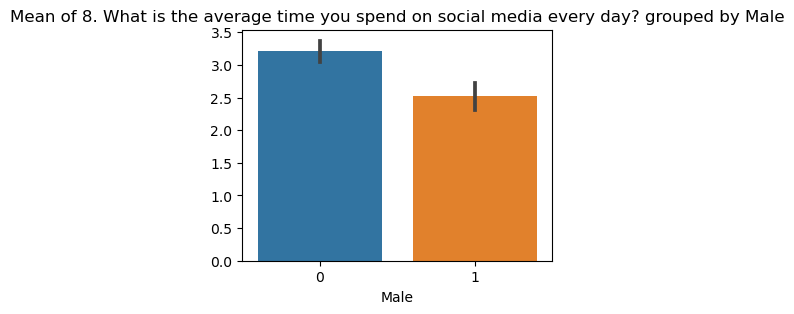


      8. What is the average time you spend on social media every day?
Male                                                                  
0                                              3.207407               
1                                              2.526066               
p-value: 0.0000; t-statistic: 4.7670



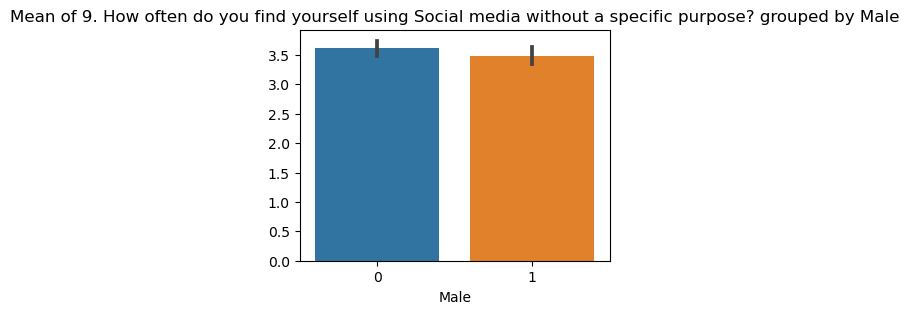


      9. How often do you find yourself using Social media without a specific purpose?
Male                                                                                  
0                                              3.611111                               
1                                              3.478673                               
p-value: 0.1889; t-statistic: 1.3157



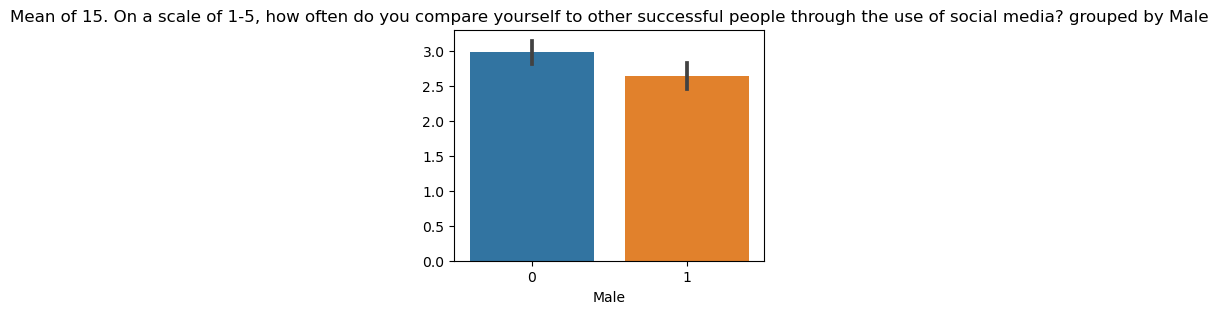


      15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?
Male                                                                                                                      
0                                              2.981481                                                                   
1                                              2.639810                                                                   
p-value: 0.0081; t-statistic: 2.6579



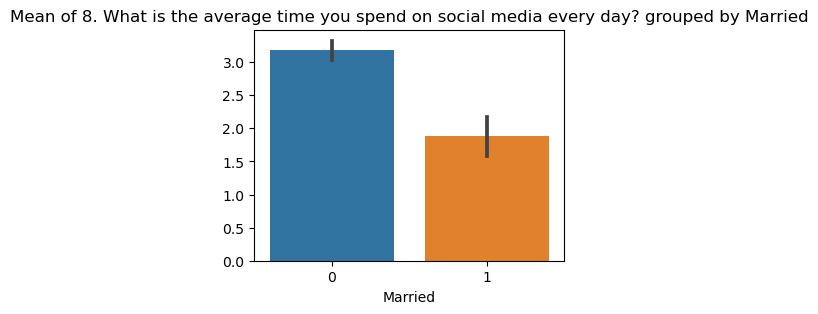


         8. What is the average time you spend on social media every day?
Married                                                                  
0                                                 3.178947               
1                                                 1.891089               
p-value: 0.0000; t-statistic: 7.6555



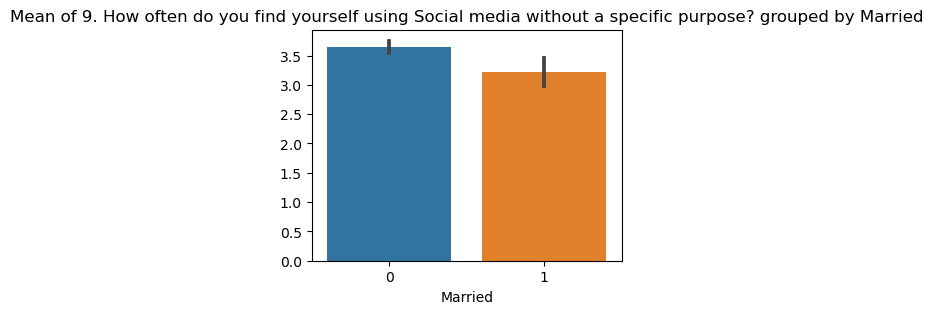


         9. How often do you find yourself using Social media without a specific purpose?
Married                                                                                  
0                                                 3.642105                               
1                                                 3.217822                               
p-value: 0.0005; t-statistic: 3.4973



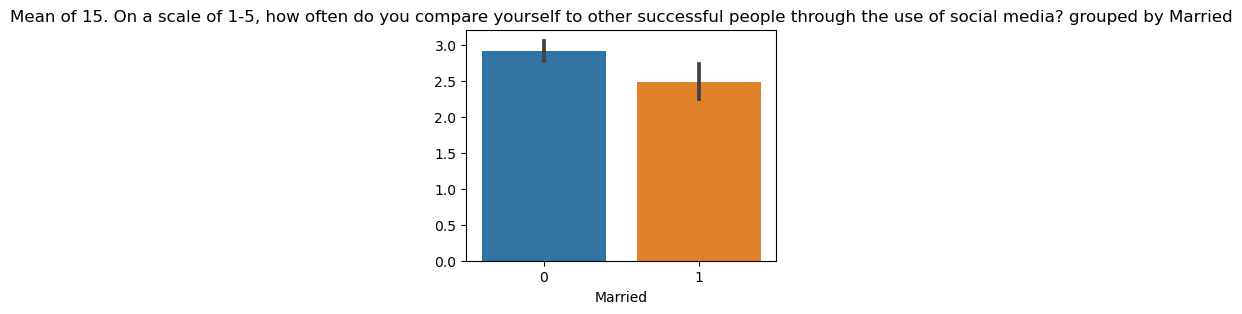


         15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?
Married                                                                                                                      
0                                                 2.923684                                                                   
1                                                 2.485149                                                                   
p-value: 0.0053; t-statistic: 2.8023



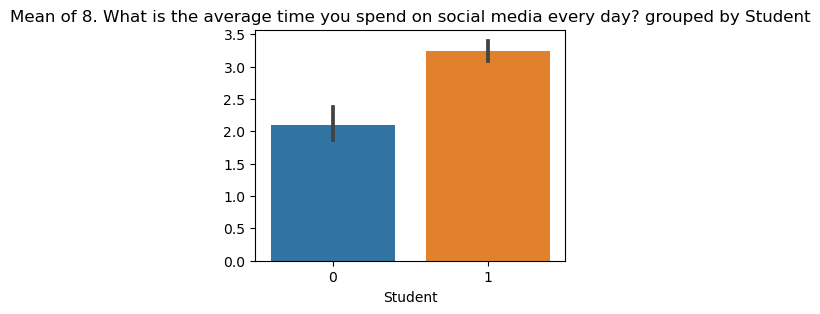


         8. What is the average time you spend on social media every day?
Student                                                                  
0                                                 2.100000               
1                                                 3.240469               
p-value: 0.0000; t-statistic: -7.5497



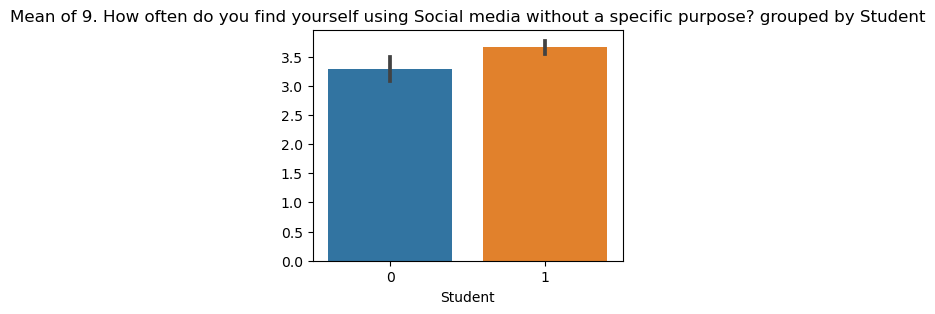


         9. How often do you find yourself using Social media without a specific purpose?
Student                                                                                  
0                                                 3.292857                               
1                                                 3.659824                               
p-value: 0.0008; t-statistic: -3.3706



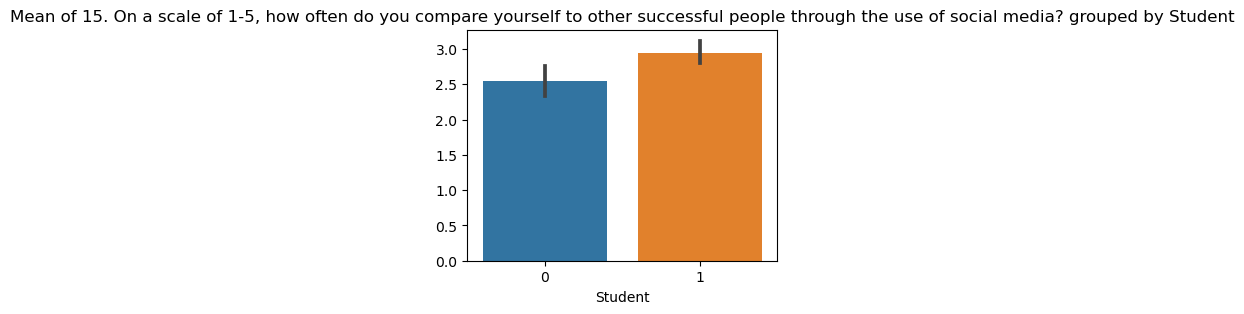


         15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?
Student                                                                                                                      
0                                                 2.542857                                                                   
1                                                 2.950147                                                                   
p-value: 0.0038; t-statistic: -2.9044



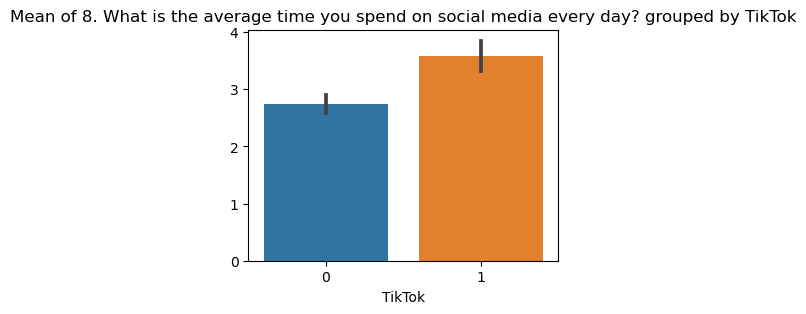


        8. What is the average time you spend on social media every day?
TikTok                                                                  
0                                                2.744186               
1                                                3.585106               
p-value: 0.0000; t-statistic: -4.6984



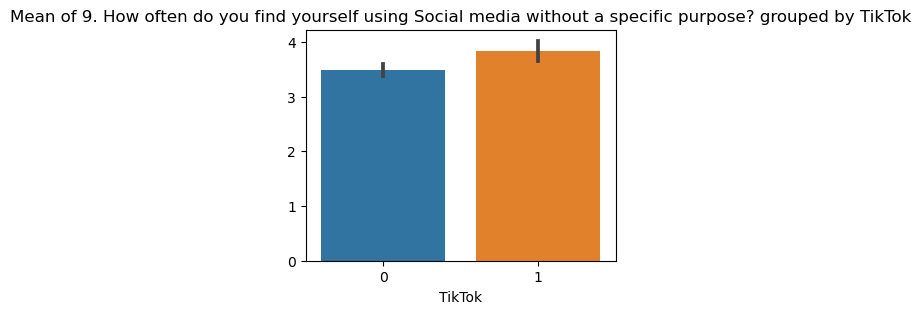


        9. How often do you find yourself using Social media without a specific purpose?
TikTok                                                                                  
0                                                3.483204                               
1                                                3.840426                               
p-value: 0.0045; t-statistic: -2.8547



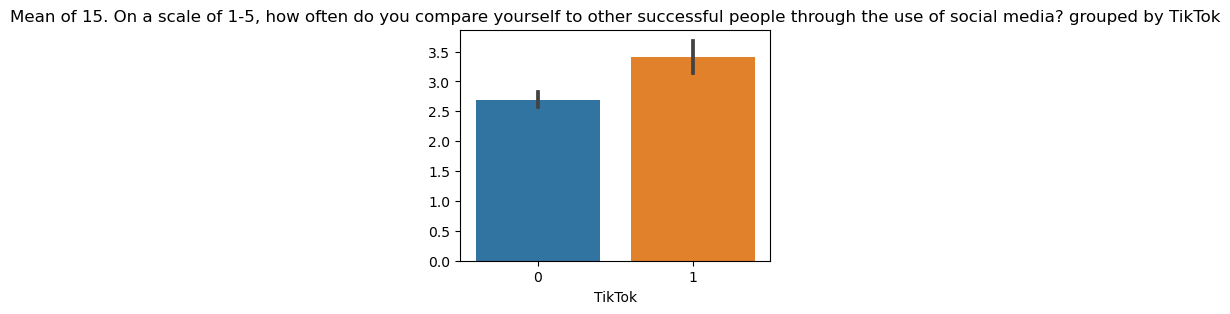


        15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?
TikTok                                                                                                                      
0                                                2.692506                                                                   
1                                                3.404255                                                                   
p-value: 0.0000; t-statistic: -4.4833



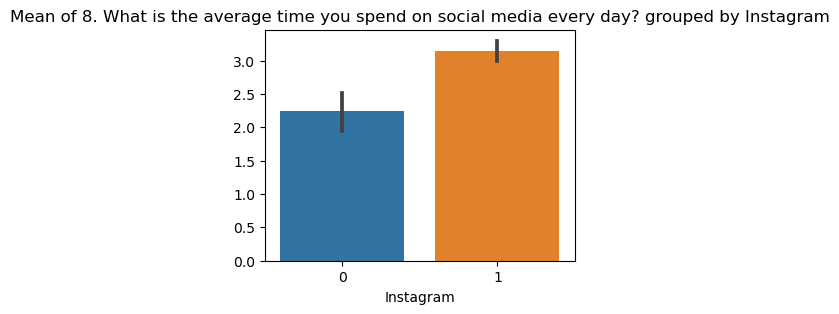


           8. What is the average time you spend on social media every day?
Instagram                                                                  
0                                                   2.237705               
1                                                   3.136490               
p-value: 0.0000; t-statistic: -5.5584



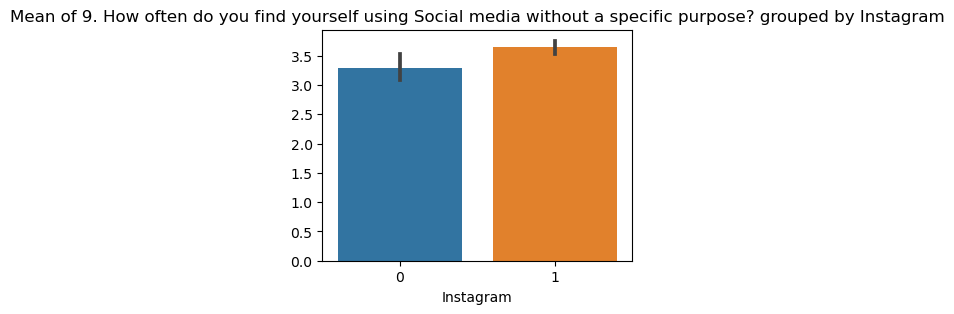


           9. How often do you find yourself using Social media without a specific purpose?
Instagram                                                                                  
0                                                   3.295082                               
1                                                   3.640669                               
p-value: 0.0025; t-statistic: -3.0336



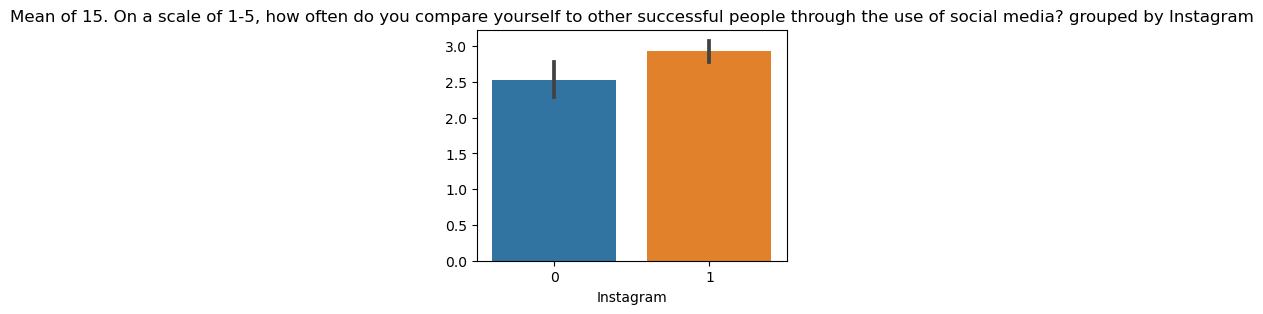


           15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?
Instagram                                                                                                                      
0                                                   2.532787                                                                   
1                                                   2.933148                                                                   
p-value: 0.0065; t-statistic: -2.7319



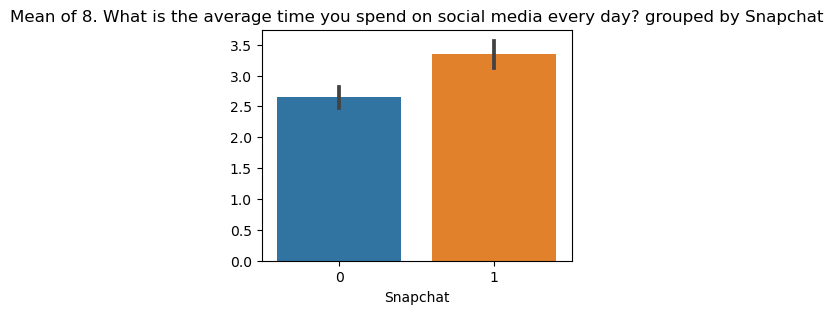


          8. What is the average time you spend on social media every day?
Snapchat                                                                  
0                                                  2.646667               
1                                                  3.342541               
p-value: 0.0000; t-statistic: -4.7525



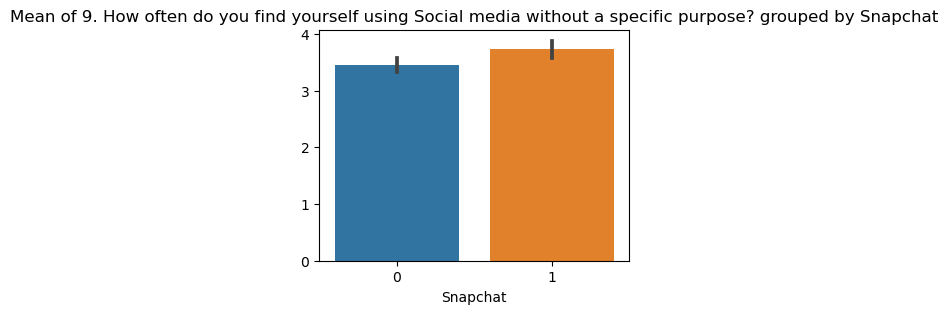


          9. How often do you find yourself using Social media without a specific purpose?
Snapchat                                                                                  
0                                                  3.450000                               
1                                                  3.723757                               
p-value: 0.0078; t-statistic: -2.6700



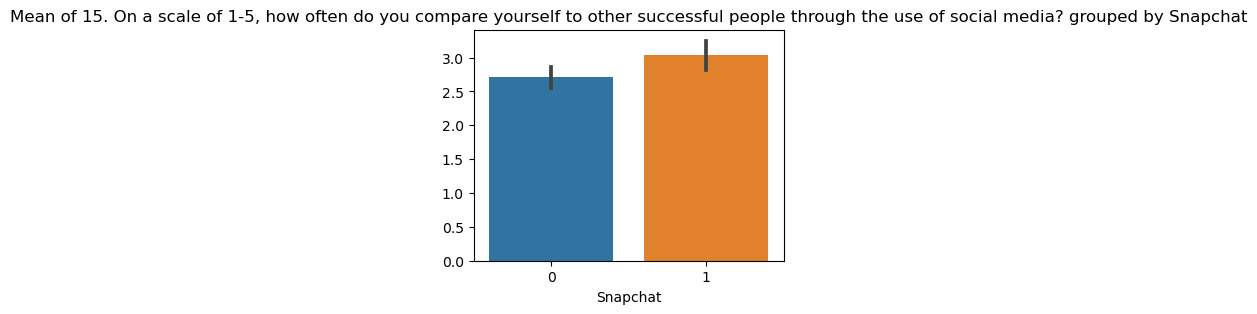


          15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?
Snapchat                                                                                                                      
0                                                  2.706667                                                                   
1                                                  3.038674                                                                   
p-value: 0.0121; t-statistic: -2.5196



In [81]:
groupby_cols = ['Male', 'Married', 'Student', 'TikTok', 'Instagram', 'Snapchat']

agg_cols = ['8. What is the average time you spend on social media every day?',
            '9. How often do you find yourself using Social media without a specific purpose?',
            '15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?']

for groupby_col in groupby_cols:
    for agg_col in agg_cols:
            get_mean_by_group_t_test_2(data, groupby_col, agg_col)

All of the results are in the direction that we would expect, and all but one (Mean of 9. How often do you find yourself using Social media without a specific purpose? grouped by Male) are significant at the .01 level. Non-men, unmarried people, and students seem to be the groups of people who are using social media the most and in the most destructive ways to their mental health (without a specific purpose and comparing themselves to other successful people on it). Users of TikTok, Instagram, and Snapchat are the most affected, and additional research should explore whether these platforms are designed to encourage these types of behaviors. Also, because users of these platforms spend more time on social media than users of other platforms, the addictive nature of these platforms should also be investigated. Vulnerable populations, such as the aforementioned ones, should be especially aware of the effects these platforms can have on their mental health.